# Import Required Classes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
import json

sns.set_style("darkgrid")

sys.path.append('../src')

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/notebooks


In [3]:
from LightGBMBaselineClassifier import LightGBMBaselineClassifier
from LightGBMTuner import LightGBMTunerCV
from MetricsCore import MetricsCalculator
from DiskIO import DiskIO

/Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/Ass2_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run Baseline LightGBM Classifier

In [4]:
baseline = LightGBMBaselineClassifier()
baseline.load_and_prepare_data()

In [6]:
baseline.train()

Classification Report:
Accuracy: 98.27%
Recall: 97.71%
Specificity: 99.63%
PPV: 98.09%
NPV: 99.64%
F1: 97.9%


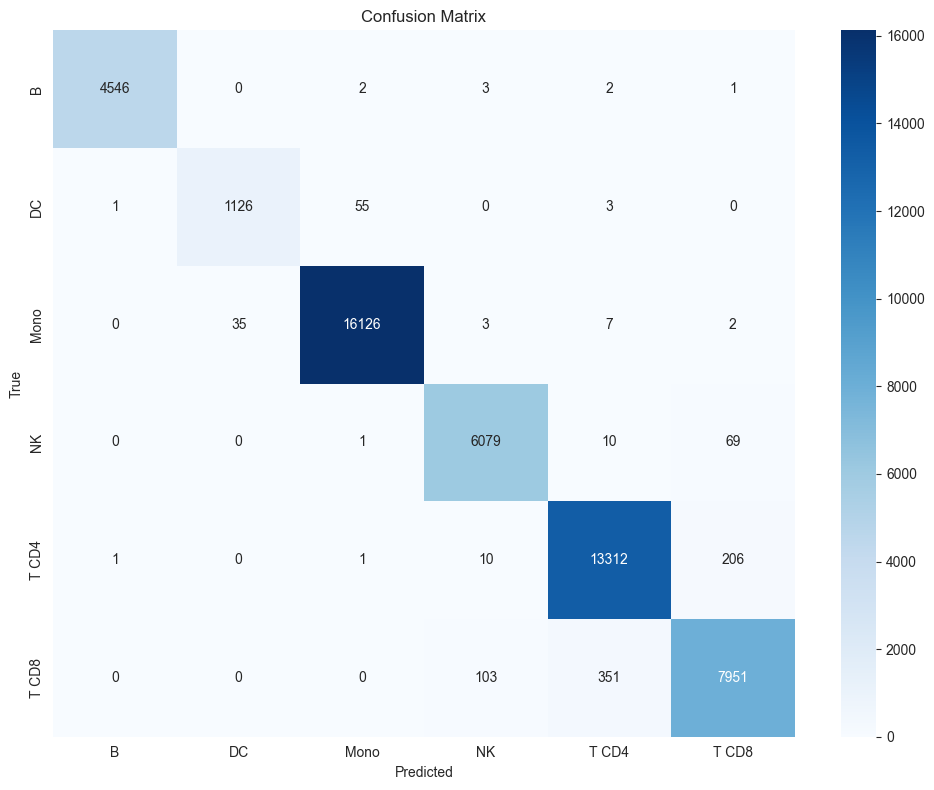

In [7]:
# Unpack the evaluation results: (train_results, test_results)
report, cm, stats = baseline.evaluate()

print("Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
baseline.plot_confusion_matrix(cm)

In [8]:
# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,1.000,0.998,0.999,4554.000
DC,0.970,0.950,0.960,1185.000
Mono,0.996,0.997,0.997,16173.000
NK,0.981,0.987,0.984,6159.000
T CD4,0.973,0.984,0.978,13530.000
T CD8,0.966,0.946,0.956,8405.000
macro avg,0.981,0.977,0.979,50006.000
weighted avg,0.983,0.983,0.983,50006.000
accuracy,NaN,NaN,NaN,0.983


In [9]:
model_name = 'baseline'
baseline.save_model(pipeline=baseline.pipeline, label_encoder=baseline.label_encoder)

# Tuning - Nested CV

In [10]:
# Initialize the tuner
tuner = LightGBMTunerCV(n_trials=50)

In [ ]:
# # Find optimal hyperparameters with Optuna
# tuner.tune_hyperparameters()

[DiskIO] Using base directory: /Users/dvoulgari/Desktop/MLCB/MLCB_Final_Project/models


[I 2025-06-26 13:20:46,235] A new study created in memory with name: no-name-27257131-b088-43c7-b034-e0f4ad7c4e43


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.0572134
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.0594499
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:20:53,317] Trial 0 finished with value: 0.981804711197249 and parameters: {'boosting_type': 'goss', 'num_leaves': 220, 'max_depth': 5, 'learning_rate': 0.06457721951441578, 'n_estimators': 96, 'min_child_samples': 86, 'feature_fraction': 0.6640494575540797, 'reg_alpha': 1.7343750741115112, 'reg_lambda': 1.159105786358738, 'max_bin': 367, 'min_gain_to_split': 0.4074246410898892, 'path_smooth': 0.5939471507625259}. Best is trial 0 with value: 0.981804711197249.


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.0552209
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[460]	valid_0's multi_logloss: 0.0671849
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[460]	valid_0's multi_logloss: 0.068179
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[460]	valid_0's multi_logloss: 0.0643027


[I 2025-06-26 13:21:16,165] Trial 1 finished with value: 0.9797069265808598 and parameters: {'boosting_type': 'goss', 'num_leaves': 130, 'max_depth': 4, 'learning_rate': 0.010267993257022524, 'n_estimators': 460, 'min_child_samples': 7, 'feature_fraction': 0.8850590887926663, 'reg_alpha': 4.114628098155189, 'reg_lambda': 0.7912075546648428, 'max_bin': 143, 'min_gain_to_split': 0.2537811032313021, 'path_smooth': 0.09068605048585454}. Best is trial 0 with value: 0.981804711197249.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's multi_logloss: 0.0531713
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's multi_logloss: 0.0553569
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's multi_logloss: 0.0514267


[I 2025-06-26 13:21:46,323] Trial 2 finished with value: 0.9828107363049642 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'max_depth': 12, 'learning_rate': 0.03592651587645153, 'n_estimators': 241, 'min_child_samples': 29, 'feature_fraction': 0.51485242208225, 'reg_alpha': 3.8154053860825767, 'reg_lambda': 0.28844445777307326, 'max_bin': 456, 'min_gain_to_split': 0.19853376024280733, 'path_smooth': 0.19751221083124815, 'bagging_fraction': 0.6330200567815882, 'bagging_freq': 2}. Best is trial 2 with value: 0.9828107363049642.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[216]	valid_0's multi_logloss: 0.0538305
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.0565019
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:21:55,103] Trial 3 finished with value: 0.9826401367816654 and parameters: {'boosting_type': 'goss', 'num_leaves': 275, 'max_depth': 10, 'learning_rate': 0.14344333955972682, 'n_estimators': 218, 'min_child_samples': 91, 'feature_fraction': 0.7367594037611901, 'reg_alpha': 1.0053845934785728, 'reg_lambda': 3.977376145329796, 'max_bin': 456, 'min_gain_to_split': 0.4241563324441764, 'path_smooth': 0.2653527517056222}. Best is trial 2 with value: 0.9828107363049642.


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.0514458
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's multi_logloss: 0.0537843
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's multi_logloss: 0.0563751
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's multi_logloss: 0.0515581


[I 2025-06-26 13:22:29,656] Trial 4 finished with value: 0.9823195142168718 and parameters: {'boosting_type': 'goss', 'num_leaves': 210, 'max_depth': 12, 'learning_rate': 0.01930591479759342, 'n_estimators': 370, 'min_child_samples': 24, 'feature_fraction': 0.6772568513487496, 'reg_alpha': 1.7212531413732486, 'reg_lambda': 0.15981320481619155, 'max_bin': 201, 'min_gain_to_split': 0.9150970557743212, 'path_smooth': 0.7180546346230038}. Best is trial 2 with value: 0.9828107363049642.
[I 2025-06-26 13:23:37,685] Trial 5 finished with value: 0.9762089884608063 and parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'max_depth': 4, 'learning_rate': 0.02777979775825303, 'n_estimators': 378, 'min_child_samples': 65, 'feature_fraction': 0.8533048152809346, 'reg_alpha': 1.63196670972661, 'reg_lambda': 0.9537312603938203, 'max_bin': 319, 'min_gain_to_split': 0.6101927893441766, 'path_smooth': 0.4496813193185458, 'bagging_fraction': 0.5188862455446392, 'bagging_freq': 7}. Best is trial 2 with

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[469]	valid_0's multi_logloss: 0.0561957
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[469]	valid_0's multi_logloss: 0.0585762
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[469]	valid_0's multi_logloss: 0.0541228


[I 2025-06-26 13:24:35,018] Trial 6 finished with value: 0.9821646746006264 and parameters: {'boosting_type': 'goss', 'num_leaves': 205, 'max_depth': 11, 'learning_rate': 0.012171008853612197, 'n_estimators': 469, 'min_child_samples': 23, 'feature_fraction': 0.6398648069425557, 'reg_alpha': 4.084553066395713, 'reg_lambda': 3.8595954869805613, 'max_bin': 90, 'min_gain_to_split': 0.17131122899099582, 'path_smooth': 0.12705719752249034}. Best is trial 2 with value: 0.9828107363049642.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[123]	valid_0's multi_logloss: 0.0633113
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[123]	valid_0's multi_logloss: 0.0646363
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:24:45,591] Trial 7 finished with value: 0.9808854514897937 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'max_depth': 5, 'learning_rate': 0.038928061552956986, 'n_estimators': 123, 'min_child_samples': 98, 'feature_fraction': 0.5745231310799457, 'reg_alpha': 3.738272064473719, 'reg_lambda': 0.32762781932316354, 'max_bin': 223, 'min_gain_to_split': 0.27326941010156036, 'path_smooth': 0.3648991515480371, 'bagging_fraction': 0.8615999216335214, 'bagging_freq': 2}. Best is trial 2 with value: 0.9828107363049642.


Did not meet early stopping. Best iteration is:
[123]	valid_0's multi_logloss: 0.0608651
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[353]	valid_0's multi_logloss: 0.0519591
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[373]	valid_0's multi_logloss: 0.055193
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[403]	valid_0's multi_logloss: 0.0502973


[I 2025-06-26 13:25:03,620] Trial 8 finished with value: 0.9825580884890304 and parameters: {'boosting_type': 'goss', 'num_leaves': 185, 'max_depth': 8, 'learning_rate': 0.04100008880887581, 'n_estimators': 482, 'min_child_samples': 67, 'feature_fraction': 0.6793915386366991, 'reg_alpha': 0.8534994914937888, 'reg_lambda': 0.944030968029228, 'max_bin': 55, 'min_gain_to_split': 0.7628534003333454, 'path_smooth': 0.48309605430586433}. Best is trial 2 with value: 0.9828107363049642.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 0.0550347
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[327]	valid_0's multi_logloss: 0.0578697
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:25:14,481] Trial 9 finished with value: 0.9822363571288184 and parameters: {'boosting_type': 'goss', 'num_leaves': 130, 'max_depth': 9, 'learning_rate': 0.08153522223466911, 'n_estimators': 372, 'min_child_samples': 75, 'feature_fraction': 0.8834986069887805, 'reg_alpha': 3.112055082573005, 'reg_lambda': 4.166293634386125, 'max_bin': 321, 'min_gain_to_split': 0.6467795651878425, 'path_smooth': 0.245011076191622}. Best is trial 2 with value: 0.9828107363049642.


Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.0531784
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.0561104
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.0590677
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:25:21,933] Trial 10 finished with value: 0.9821391529616154 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 7, 'learning_rate': 0.285077243095517, 'n_estimators': 232, 'min_child_samples': 45, 'feature_fraction': 0.5122674515348664, 'reg_alpha': 4.953396859791493, 'reg_lambda': 2.159747624994853, 'max_bin': 494, 'min_gain_to_split': 0.017197168340836788, 'path_smooth': 0.9400991778817129, 'bagging_fraction': 0.6077472680563978, 'bagging_freq': 0}. Best is trial 2 with value: 0.9828107363049642.


Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.0536937
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.0542073
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.0572614
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:25:32,823] Trial 11 finished with value: 0.982235859260855 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 270, 'max_depth': 10, 'learning_rate': 0.1273551798096799, 'n_estimators': 204, 'min_child_samples': 47, 'feature_fraction': 0.787364128464989, 'reg_alpha': 0.14532377263923824, 'reg_lambda': 3.026043451981436, 'max_bin': 496, 'min_gain_to_split': 0.4468181452984685, 'path_smooth': 0.2550629445720359, 'bagging_fraction': 0.7156292774582685, 'bagging_freq': 4}. Best is trial 2 with value: 0.9828107363049642.


Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.0523564


[I 2025-06-26 13:26:32,358] Trial 12 finished with value: 0.9825373062855255 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 12, 'learning_rate': 0.15499341186086202, 'n_estimators': 185, 'min_child_samples': 31, 'feature_fraction': 0.9575877431336616, 'reg_alpha': 2.711593833764213, 'reg_lambda': 4.914205061952831, 'max_bin': 412, 'min_gain_to_split': 0.011659877093961213, 'path_smooth': 0.0036090913146265002, 'bagging_fraction': 0.9847111213292123, 'bagging_freq': 9}. Best is trial 2 with value: 0.9828107363049642.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.0535542
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.0562526
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:26:45,142] Trial 13 finished with value: 0.9828076197124934 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'max_depth': 10, 'learning_rate': 0.1057266362483554, 'n_estimators': 290, 'min_child_samples': 97, 'feature_fraction': 0.7480509265338475, 'reg_alpha': 0.08732652453938439, 'reg_lambda': 2.1490102376387554, 'max_bin': 417, 'min_gain_to_split': 0.36756307831085416, 'path_smooth': 0.2727215222602529, 'bagging_fraction': 0.6810197501991245, 'bagging_freq': 4}. Best is trial 2 with value: 0.9828107363049642.


Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.0518972
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.0522101
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.0544655
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:27:05,989] Trial 14 finished with value: 0.98260716873925 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'max_depth': 11, 'learning_rate': 0.08570822581591717, 'n_estimators': 300, 'min_child_samples': 35, 'feature_fraction': 0.5115703843793807, 'reg_alpha': 0.06005903755217927, 'reg_lambda': 2.069931222727923, 'max_bin': 383, 'min_gain_to_split': 0.19336267334162816, 'path_smooth': 0.6296961691261717, 'bagging_fraction': 0.6867393606715018, 'bagging_freq': 4}. Best is trial 2 with value: 0.9828107363049642.


Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.0504679
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.0565025
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.0615753
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:27:13,841] Trial 15 finished with value: 0.9815844197891486 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'max_depth': 7, 'learning_rate': 0.27265145656249523, 'n_estimators': 292, 'min_child_samples': 7, 'feature_fraction': 0.5899741929322566, 'reg_alpha': 4.9070081286931355, 'reg_lambda': 1.6150299001110042, 'max_bin': 430, 'min_gain_to_split': 0.3204327399694318, 'path_smooth': 0.3564482599427053, 'bagging_fraction': 0.6103811994088171, 'bagging_freq': 2}. Best is trial 2 with value: 0.9828107363049642.


Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.055465
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[148]	valid_0's multi_logloss: 0.0724387
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[148]	valid_0's multi_logloss: 0.074225
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:27:30,578] Trial 16 finished with value: 0.9797973281403566 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'max_depth': 9, 'learning_rate': 0.022420083886966684, 'n_estimators': 148, 'min_child_samples': 58, 'feature_fraction': 0.9824047469205102, 'reg_alpha': 3.2715561739747656, 'reg_lambda': 3.070720596643741, 'max_bin': 309, 'min_gain_to_split': 0.5713449262194064, 'path_smooth': 0.15142666692128304, 'bagging_fraction': 0.8075992453941909, 'bagging_freq': 5}. Best is trial 2 with value: 0.9828107363049642.


Did not meet early stopping. Best iteration is:
[148]	valid_0's multi_logloss: 0.0697295
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.053009
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[246]	valid_0's multi_logloss: 0.0558781
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[217]	valid_0's multi_logloss: 0.0520614


[I 2025-06-26 13:28:00,365] Trial 17 finished with value: 0.9828273346333519 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 12, 'learning_rate': 0.04829122379121936, 'n_estimators': 269, 'min_child_samples': 79, 'feature_fraction': 0.7709699896096598, 'reg_alpha': 2.2423110208129478, 'reg_lambda': 2.817869159682546, 'max_bin': 364, 'min_gain_to_split': 0.10762420312044654, 'path_smooth': 0.3849676287856901, 'bagging_fraction': 0.6450099383103124, 'bagging_freq': 2}. Best is trial 17 with value: 0.9828273346333519.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[306]	valid_0's multi_logloss: 0.0532309
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[306]	valid_0's multi_logloss: 0.0564821
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[240]	valid_0's multi_logloss: 0.0525222


[I 2025-06-26 13:28:24,721] Trial 18 finished with value: 0.9824442977645517 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.04518644547802105, 'n_estimators': 339, 'min_child_samples': 76, 'feature_fraction': 0.837155386400303, 'reg_alpha': 2.4554720913384447, 'reg_lambda': 3.0097112427698867, 'max_bin': 263, 'min_gain_to_split': 0.12017494701470191, 'path_smooth': 0.8182356938001704, 'bagging_fraction': 0.5069858856806412, 'bagging_freq': 0}. Best is trial 17 with value: 0.9828273346333519.
[I 2025-06-26 13:28:35,128] Trial 19 finished with value: 0.9762081305741348 and parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'max_depth': 11, 'learning_rate': 0.031641100777232825, 'n_estimators': 66, 'min_child_samples': 39, 'feature_fraction': 0.7912476189693385, 'reg_alpha': 2.2792668046093967, 'reg_lambda': 1.5159121638630515, 'max_bin': 358, 'min_gain_to_split': 0.10038160248680852, 'path_smooth': 0.39107341594392536, 'bagging_fracti

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[236]	valid_0's multi_logloss: 0.0648258
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[236]	valid_0's multi_logloss: 0.066596
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[236]	valid_0's multi_logloss: 0.0621271


[I 2025-06-26 13:29:05,652] Trial 20 finished with value: 0.9811588055105723 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.01644698321580012, 'n_estimators': 236, 'min_child_samples': 56, 'feature_fraction': 0.7236805348878828, 'reg_alpha': 3.4552305628888567, 'reg_lambda': 2.6670705655378106, 'max_bin': 460, 'min_gain_to_split': 0.10432669667770667, 'path_smooth': 0.5683242786987075, 'bagging_fraction': 0.8095633740809706, 'bagging_freq': 2}. Best is trial 17 with value: 0.9828273346333519.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.0525207
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.0559858
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.0515938


[I 2025-06-26 13:29:25,208] Trial 21 finished with value: 0.9827513576701016 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'max_depth': 12, 'learning_rate': 0.06073185353053191, 'n_estimators': 277, 'min_child_samples': 99, 'feature_fraction': 0.7819560316361336, 'reg_alpha': 0.7323856323805941, 'reg_lambda': 2.2039984254372342, 'max_bin': 402, 'min_gain_to_split': 0.32396058221331836, 'path_smooth': 0.2266357213256884, 'bagging_fraction': 0.6585814421595454, 'bagging_freq': 3}. Best is trial 17 with value: 0.9828273346333519.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[182]	valid_0's multi_logloss: 0.0531684
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[194]	valid_0's multi_logloss: 0.0555744
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:29:41,800] Trial 22 finished with value: 0.98292462796398 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'max_depth': 10, 'learning_rate': 0.09456713900695703, 'n_estimators': 319, 'min_child_samples': 86, 'feature_fraction': 0.6017452848178806, 'reg_alpha': 4.222484271189848, 'reg_lambda': 3.5649178645305923, 'max_bin': 450, 'min_gain_to_split': 0.22004488640110276, 'path_smooth': 0.32920756218703684, 'bagging_fraction': 0.7501445686950143, 'bagging_freq': 6}. Best is trial 22 with value: 0.98292462796398.


Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.0515991
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[285]	valid_0's multi_logloss: 0.0528589
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0552701
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[333]	valid_0's multi_logloss: 0.0513133


[I 2025-06-26 13:30:10,659] Trial 23 finished with value: 0.9831333384245063 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'max_depth': 11, 'learning_rate': 0.04855235866593165, 'n_estimators': 334, 'min_child_samples': 81, 'feature_fraction': 0.5632071707396625, 'reg_alpha': 4.475209950692005, 'reg_lambda': 3.5264423551855946, 'max_bin': 463, 'min_gain_to_split': 0.2119523814352596, 'path_smooth': 0.42180392234855685, 'bagging_fraction': 0.7760907749076289, 'bagging_freq': 6}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.0527321
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 0.0549708
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[232]	valid_0's multi_logloss: 0.05124


[I 2025-06-26 13:30:40,814] Trial 24 finished with value: 0.9829230687372336 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'max_depth': 11, 'learning_rate': 0.054202359912729293, 'n_estimators': 417, 'min_child_samples': 83, 'feature_fraction': 0.5791892831650614, 'reg_alpha': 4.410800637840576, 'reg_lambda': 3.531813618410976, 'max_bin': 364, 'min_gain_to_split': 0.059457417139783746, 'path_smooth': 0.4349889623060844, 'bagging_fraction': 0.7734122206499765, 'bagging_freq': 7}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.0537804
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.0575553
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:30:51,409] Trial 25 finished with value: 0.9824572583164807 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'max_depth': 8, 'learning_rate': 0.20052124554181538, 'n_estimators': 413, 'min_child_samples': 85, 'feature_fraction': 0.574749575601506, 'reg_alpha': 4.380973261215877, 'reg_lambda': 3.510039502365586, 'max_bin': 469, 'min_gain_to_split': 0.014497809428124668, 'path_smooth': 0.49686849080985035, 'bagging_fraction': 0.770760152621747, 'bagging_freq': 7}. Best is trial 23 with value: 0.9831333384245063.


Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.0530185


[I 2025-06-26 13:33:15,552] Trial 26 finished with value: 0.9822335066076929 and parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'max_depth': 10, 'learning_rate': 0.07174732530590672, 'n_estimators': 420, 'min_child_samples': 68, 'feature_fraction': 0.6145894157198356, 'reg_alpha': 4.628656335767514, 'reg_lambda': 4.680980495963226, 'max_bin': 339, 'min_gain_to_split': 0.5204600101459995, 'path_smooth': 0.6641055767608748, 'bagging_fraction': 0.8801435095486823, 'bagging_freq': 7}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[155]	valid_0's multi_logloss: 0.0536159
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.0560216
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:33:29,090] Trial 27 finished with value: 0.9826640696403484 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'max_depth': 11, 'learning_rate': 0.10020740930397565, 'n_estimators': 338, 'min_child_samples': 88, 'feature_fraction': 0.5462389515103541, 'reg_alpha': 4.4916496208220416, 'reg_lambda': 3.4421589067147806, 'max_bin': 271, 'min_gain_to_split': 0.2565949802002773, 'path_smooth': 0.5385088801044664, 'bagging_fraction': 0.7367022434802075, 'bagging_freq': 9}. Best is trial 23 with value: 0.9831333384245063.


Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 0.0517774
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[273]	valid_0's multi_logloss: 0.052291
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[292]	valid_0's multi_logloss: 0.0547029
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.0515192


[I 2025-06-26 13:33:58,799] Trial 28 finished with value: 0.982814292797619 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'max_depth': 9, 'learning_rate': 0.056012821190962465, 'n_estimators': 401, 'min_child_samples': 79, 'feature_fraction': 0.6134504487024725, 'reg_alpha': 2.926370285926203, 'reg_lambda': 4.3444250500952135, 'max_bin': 429, 'min_gain_to_split': 0.1657056907581247, 'path_smooth': 0.4397372523986937, 'bagging_fraction': 0.8609881372270284, 'bagging_freq': 6}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0530782
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[270]	valid_0's multi_logloss: 0.0555741
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 0.0518561


[I 2025-06-26 13:34:19,675] Trial 29 finished with value: 0.9826879707826931 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'max_depth': 11, 'learning_rate': 0.06139954723539188, 'n_estimators': 337, 'min_child_samples': 84, 'feature_fraction': 0.6499499523866342, 'reg_alpha': 3.612668356255446, 'reg_lambda': 3.403562750441979, 'max_bin': 382, 'min_gain_to_split': 0.37319221524651297, 'path_smooth': 0.3034311314929346, 'bagging_fraction': 0.7936426779655207, 'bagging_freq': 8}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.0539804
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.0575778
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:34:27,942] Trial 30 finished with value: 0.9822869230526926 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'max_depth': 6, 'learning_rate': 0.18894015054578164, 'n_estimators': 436, 'min_child_samples': 92, 'feature_fraction': 0.544455247330081, 'reg_alpha': 4.19868136408772, 'reg_lambda': 3.6893030827717506, 'max_bin': 445, 'min_gain_to_split': 0.4661298246693959, 'path_smooth': 0.7317297113251232, 'bagging_fraction': 0.9118187110226437, 'bagging_freq': 6}. Best is trial 23 with value: 0.9831333384245063.


Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.0529971
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[271]	valid_0's multi_logloss: 0.0533489
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[324]	valid_0's multi_logloss: 0.0560837
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[293]	valid_0's multi_logloss: 0.0522376


[I 2025-06-26 13:34:55,532] Trial 31 finished with value: 0.9824569182987347 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'max_depth': 11, 'learning_rate': 0.0483657417453086, 'n_estimators': 324, 'min_child_samples': 81, 'feature_fraction': 0.6969371963763443, 'reg_alpha': 4.690992300746841, 'reg_lambda': 2.634488231003441, 'max_bin': 372, 'min_gain_to_split': 0.0890685395232217, 'path_smooth': 0.3916319149903191, 'bagging_fraction': 0.7417374367444343, 'bagging_freq': 6}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 0.0529644
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[155]	valid_0's multi_logloss: 0.0552982
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:35:18,683] Trial 32 finished with value: 0.9827379896137852 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 10, 'learning_rate': 0.07326366761694594, 'n_estimators': 270, 'min_child_samples': 72, 'feature_fraction': 0.6150409468586989, 'reg_alpha': 2.1945922615307722, 'reg_lambda': 3.2296424193383175, 'max_bin': 349, 'min_gain_to_split': 0.0555348145926876, 'path_smooth': 0.3292179203119986, 'bagging_fraction': 0.7680348352647939, 'bagging_freq': 5}. Best is trial 23 with value: 0.9831333384245063.


Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.0515248
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[259]	valid_0's multi_logloss: 0.0559108
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[259]	valid_0's multi_logloss: 0.0583973
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:35:32,385] Trial 33 finished with value: 0.9819326882762011 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'max_depth': 3, 'learning_rate': 0.04982905059215467, 'n_estimators': 259, 'min_child_samples': 92, 'feature_fraction': 0.5483465674492728, 'reg_alpha': 4.150434755728249, 'reg_lambda': 4.420755684701554, 'max_bin': 294, 'min_gain_to_split': 0.23004486426200904, 'path_smooth': 0.4359642308208828, 'bagging_fraction': 0.8297962362099902, 'bagging_freq': 10}. Best is trial 23 with value: 0.9831333384245063.


Did not meet early stopping. Best iteration is:
[259]	valid_0's multi_logloss: 0.0542037
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[404]	valid_0's multi_logloss: 0.0532496
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[441]	valid_0's multi_logloss: 0.0553111
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[392]	valid_0's multi_logloss: 0.0519222


[I 2025-06-26 13:36:11,812] Trial 34 finished with value: 0.9829613831317369 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'max_depth': 12, 'learning_rate': 0.02869467072958674, 'n_estimators': 443, 'min_child_samples': 61, 'feature_fraction': 0.6366678072842935, 'reg_alpha': 3.950160035786705, 'reg_lambda': 2.783570627974381, 'max_bin': 395, 'min_gain_to_split': 0.15535332112268774, 'path_smooth': 0.5278949716934228, 'bagging_fraction': 0.5670443554217685, 'bagging_freq': 8}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[463]	valid_0's multi_logloss: 0.0529734
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[496]	valid_0's multi_logloss: 0.055327
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[392]	valid_0's multi_logloss: 0.0520846


[I 2025-06-26 13:36:53,378] Trial 35 finished with value: 0.9831087714605338 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 295, 'max_depth': 10, 'learning_rate': 0.026827380424621957, 'n_estimators': 496, 'min_child_samples': 62, 'feature_fraction': 0.6391376831046449, 'reg_alpha': 3.96613121451898, 'reg_lambda': 3.8873433156445305, 'max_bin': 475, 'min_gain_to_split': 0.1509186341142724, 'path_smooth': 0.5592141808954122, 'bagging_fraction': 0.5480878912278535, 'bagging_freq': 8}. Best is trial 23 with value: 0.9831333384245063.
[I 2025-06-26 13:39:17,527] Trial 36 finished with value: 0.9791162284258633 and parameters: {'boosting_type': 'dart', 'num_leaves': 300, 'max_depth': 10, 'learning_rate': 0.026417036053390196, 'n_estimators': 455, 'min_child_samples': 61, 'feature_fraction': 0.7069216347339279, 'reg_alpha': 3.905247264101642, 'reg_lambda': 3.979190995165798, 'max_bin': 473, 'min_gain_to_split': 0.3008955703404136, 'path_smooth': 0.552178859465285, 'bagging_fraction'

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[488]	valid_0's multi_logloss: 0.0537403
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[488]	valid_0's multi_logloss: 0.0562263
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[488]	valid_0's multi_logloss: 0.0521981


[I 2025-06-26 13:40:03,488] Trial 37 finished with value: 0.9824535609832754 and parameters: {'boosting_type': 'goss', 'num_leaves': 300, 'max_depth': 8, 'learning_rate': 0.01790038605680968, 'n_estimators': 488, 'min_child_samples': 53, 'feature_fraction': 0.6416348848145721, 'reg_alpha': 3.956706346330656, 'reg_lambda': 3.760351714511575, 'max_bin': 399, 'min_gain_to_split': 0.22084003470731356, 'path_smooth': 0.6105162927097489}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[384]	valid_0's multi_logloss: 0.0528524
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[441]	valid_0's multi_logloss: 0.0553108
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[393]	valid_0's multi_logloss: 0.052032


[I 2025-06-26 13:40:42,338] Trial 38 finished with value: 0.9830987982742881 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'max_depth': 10, 'learning_rate': 0.03245359557947582, 'n_estimators': 448, 'min_child_samples': 62, 'feature_fraction': 0.663522694852055, 'reg_alpha': 3.527219555477394, 'reg_lambda': 4.095337378657556, 'max_bin': 481, 'min_gain_to_split': 0.16085421098570418, 'path_smooth': 0.6964762245014436, 'bagging_fraction': 0.5681841975930785, 'bagging_freq': 8}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[454]	valid_0's multi_logloss: 0.0539144
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[394]	valid_0's multi_logloss: 0.057362
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[450]	valid_0's multi_logloss: 0.0525944


[I 2025-06-26 13:41:05,496] Trial 39 finished with value: 0.9824461901476443 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 12, 'learning_rate': 0.034592365043259944, 'n_estimators': 454, 'min_child_samples': 62, 'feature_fraction': 0.6696965333806358, 'reg_alpha': 3.587178865632635, 'reg_lambda': 4.503934949764868, 'max_bin': 499, 'min_gain_to_split': 0.9860404830514816, 'path_smooth': 0.7619512803072612, 'bagging_fraction': 0.566295913072679, 'bagging_freq': 9}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's multi_logloss: 0.0544448
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's multi_logloss: 0.0569699
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's multi_logloss: 0.0526327


[I 2025-06-26 13:41:56,964] Trial 40 finished with value: 0.9824522687812577 and parameters: {'boosting_type': 'goss', 'num_leaves': 210, 'max_depth': 9, 'learning_rate': 0.01367967417639761, 'n_estimators': 499, 'min_child_samples': 45, 'feature_fraction': 0.6321943714277647, 'reg_alpha': 3.4045805343080993, 'reg_lambda': 4.167158728012037, 'max_bin': 169, 'min_gain_to_split': 0.13874917265192416, 'path_smooth': 0.8761972202345479}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[377]	valid_0's multi_logloss: 0.0530268
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[396]	valid_0's multi_logloss: 0.0557164
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[348]	valid_0's multi_logloss: 0.0520281


[I 2025-06-26 13:42:27,444] Trial 41 finished with value: 0.983022445822867 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 10, 'learning_rate': 0.03729434030645043, 'n_estimators': 396, 'min_child_samples': 70, 'feature_fraction': 0.6617299723373837, 'reg_alpha': 3.7936451147620485, 'reg_lambda': 3.9789517374283636, 'max_bin': 446, 'min_gain_to_split': 0.17695508244354816, 'path_smooth': 0.6797215601832916, 'bagging_fraction': 0.5621727688286686, 'bagging_freq': 8}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[386]	valid_0's multi_logloss: 0.0537658
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.0568059
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.0529733


[I 2025-06-26 13:43:04,558] Trial 42 finished with value: 0.9827485671089988 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 11, 'learning_rate': 0.021371801928873307, 'n_estimators': 388, 'min_child_samples': 72, 'feature_fraction': 0.6938258185096408, 'reg_alpha': 3.8145508227920244, 'reg_lambda': 4.073266781356348, 'max_bin': 482, 'min_gain_to_split': 0.16559718585658692, 'path_smooth': 0.6830299159514658, 'bagging_fraction': 0.5659195961777838, 'bagging_freq': 8}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[468]	valid_0's multi_logloss: 0.0530644
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[436]	valid_0's multi_logloss: 0.0558895
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[437]	valid_0's multi_logloss: 0.0522247


[I 2025-06-26 13:43:40,656] Trial 43 finished with value: 0.9828379822549914 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'max_depth': 12, 'learning_rate': 0.027787755196947657, 'n_estimators': 468, 'min_child_samples': 69, 'feature_fraction': 0.6644419843996014, 'reg_alpha': 3.1913444165468063, 'reg_lambda': 4.729876826525335, 'max_bin': 439, 'min_gain_to_split': 0.28185220490879886, 'path_smooth': 0.7958405600332229, 'bagging_fraction': 0.5437031450681429, 'bagging_freq': 10}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[376]	valid_0's multi_logloss: 0.0533862
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[437]	valid_0's multi_logloss: 0.0559975
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[392]	valid_0's multi_logloss: 0.0520773


[I 2025-06-26 13:44:09,165] Trial 44 finished with value: 0.982950856921036 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'max_depth': 9, 'learning_rate': 0.03183711695717897, 'n_estimators': 437, 'min_child_samples': 63, 'feature_fraction': 0.7253244699041635, 'reg_alpha': 3.745960321038764, 'reg_lambda': 3.8730145990999243, 'max_bin': 474, 'min_gain_to_split': 0.3683942489881201, 'path_smooth': 0.6553655513840518, 'bagging_fraction': 0.5888045689849449, 'bagging_freq': 8}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[371]	valid_0's multi_logloss: 0.0535001
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's multi_logloss: 0.0561692
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[371]	valid_0's multi_logloss: 0.0519413


[I 2025-06-26 13:44:32,389] Trial 45 finished with value: 0.9825303160370756 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'max_depth': 11, 'learning_rate': 0.038252892185843025, 'n_estimators': 371, 'min_child_samples': 54, 'feature_fraction': 0.631944344488289, 'reg_alpha': 2.844924964499588, 'reg_lambda': 3.2899674932911736, 'max_bin': 453, 'min_gain_to_split': 0.687203337247003, 'path_smooth': 0.5274874129621199, 'bagging_fraction': 0.5250449910875694, 'bagging_freq': 9}. Best is trial 23 with value: 0.9831333384245063.
[I 2025-06-26 13:46:58,258] Trial 46 finished with value: 0.9791596036260879 and parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'max_depth': 10, 'learning_rate': 0.023458687753645558, 'n_estimators': 439, 'min_child_samples': 59, 'feature_fraction': 0.5626708191568086, 'reg_alpha': 3.9797070546734603, 'reg_lambda': 4.245628386237601, 'max_bin': 420, 'min_gain_to_split': 0.15335525126537425, 'path_smooth': 0.5894687217672109, 'bagging_fractio

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[353]	valid_0's multi_logloss: 0.055054
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[359]	valid_0's multi_logloss: 0.0574617
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[361]	valid_0's multi_logloss: 0.0530401


[I 2025-06-26 13:47:16,201] Trial 47 finished with value: 0.9822349896560661 and parameters: {'boosting_type': 'goss', 'num_leaves': 280, 'max_depth': 8, 'learning_rate': 0.04105770180218837, 'n_estimators': 361, 'min_child_samples': 49, 'feature_fraction': 0.6814499346480739, 'reg_alpha': 4.860452136876831, 'reg_lambda': 3.77422012505824, 'max_bin': 487, 'min_gain_to_split': 0.8068556140816562, 'path_smooth': 0.6978106880917456}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[479]	valid_0's multi_logloss: 0.053353
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[479]	valid_0's multi_logloss: 0.0557059
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[479]	valid_0's multi_logloss: 0.0521891


[I 2025-06-26 13:48:00,294] Trial 48 finished with value: 0.9826890642516442 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 10, 'learning_rate': 0.025447067874684655, 'n_estimators': 479, 'min_child_samples': 66, 'feature_fraction': 0.5305765757607672, 'reg_alpha': 4.633150745134789, 'reg_lambda': 4.992846826670033, 'max_bin': 397, 'min_gain_to_split': 0.18776931440071232, 'path_smooth': 0.4870870297474807, 'bagging_fraction': 0.5467924131665161, 'bagging_freq': 7}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[380]	valid_0's multi_logloss: 0.0531744
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[392]	valid_0's multi_logloss: 0.0558627
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[392]	valid_0's multi_logloss: 0.0524606


[I 2025-06-26 13:48:34,123] Trial 49 finished with value: 0.9825680069063942 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 285, 'max_depth': 12, 'learning_rate': 0.029463874430192154, 'n_estimators': 392, 'min_child_samples': 73, 'feature_fraction': 0.6522405961185487, 'reg_alpha': 3.0358327616002003, 'reg_lambda': 2.8701825761496518, 'max_bin': 462, 'min_gain_to_split': 0.25095621899012444, 'path_smooth': 0.6264795564345721, 'bagging_fraction': 0.5017486891065748, 'bagging_freq': 10}. Best is trial 23 with value: 0.9831333384245063.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0542609


[I 2025-06-26 13:48:48,192] A new study created in memory with name: no-name-dca8f824-fba8-4ca3-9174-226ae7874a47


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[102]	valid_0's multi_logloss: 0.190769
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[102]	valid_0's multi_logloss: 0.194607
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:49:01,381] Trial 0 finished with value: 0.9780451995974696 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 295, 'max_depth': 9, 'learning_rate': 0.014731549457765662, 'n_estimators': 102, 'min_child_samples': 29, 'feature_fraction': 0.5470287251318622, 'reg_alpha': 1.8885513794911284, 'reg_lambda': 3.696667392049055, 'max_bin': 268, 'min_gain_to_split': 0.48150361803238895, 'path_smooth': 0.398476575473797, 'bagging_fraction': 0.5937451967779077, 'bagging_freq': 3}. Best is trial 0 with value: 0.9780451995974696.


Did not meet early stopping. Best iteration is:
[102]	valid_0's multi_logloss: 0.194467
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[165]	valid_0's multi_logloss: 0.0801738
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[165]	valid_0's multi_logloss: 0.0812963
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:49:15,981] Trial 1 finished with value: 0.979632806525235 and parameters: {'boosting_type': 'goss', 'num_leaves': 200, 'max_depth': 6, 'learning_rate': 0.017601746872785196, 'n_estimators': 165, 'min_child_samples': 11, 'feature_fraction': 0.7063890006897491, 'reg_alpha': 1.1477474853961056, 'reg_lambda': 4.326936172908786, 'max_bin': 134, 'min_gain_to_split': 0.9908463171090498, 'path_smooth': 0.7908493032211888}. Best is trial 1 with value: 0.979632806525235.


Did not meet early stopping. Best iteration is:
[165]	valid_0's multi_logloss: 0.0814108


[I 2025-06-26 13:50:01,660] Trial 2 finished with value: 0.9816433704742228 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.0681385442631425, 'n_estimators': 221, 'min_child_samples': 76, 'feature_fraction': 0.6156678327906198, 'reg_alpha': 0.3101550515004131, 'reg_lambda': 0.06169405075800882, 'max_bin': 142, 'min_gain_to_split': 0.2023270282502313, 'path_smooth': 0.5524805184470727, 'bagging_fraction': 0.5383539294958255, 'bagging_freq': 6}. Best is trial 2 with value: 0.9816433704742228.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.053522
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.0538229
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:50:08,948] Trial 3 finished with value: 0.9828869439890587 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'max_depth': 6, 'learning_rate': 0.18075095438140326, 'n_estimators': 403, 'min_child_samples': 97, 'feature_fraction': 0.6429189060748528, 'reg_alpha': 2.4719194450224933, 'reg_lambda': 0.4212932534795949, 'max_bin': 484, 'min_gain_to_split': 0.3334038724775984, 'path_smooth': 0.25117135023340165, 'bagging_fraction': 0.5143574695514733, 'bagging_freq': 2}. Best is trial 3 with value: 0.9828869439890587.


Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.0548966


[I 2025-06-26 13:52:06,931] Trial 4 finished with value: 0.9787594804112424 and parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'max_depth': 10, 'learning_rate': 0.026225750914206394, 'n_estimators': 354, 'min_child_samples': 33, 'feature_fraction': 0.9314096616795, 'reg_alpha': 3.040489878065158, 'reg_lambda': 3.763118225123208, 'max_bin': 278, 'min_gain_to_split': 0.04278740974933304, 'path_smooth': 0.6793774514295305, 'bagging_fraction': 0.726272705543286, 'bagging_freq': 7}. Best is trial 3 with value: 0.9828869439890587.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[461]	valid_0's multi_logloss: 0.0560126
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[461]	valid_0's multi_logloss: 0.0574192
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[461]	valid_0's multi_logloss: 0.0571342


[I 2025-06-26 13:52:28,493] Trial 5 finished with value: 0.9822011758497221 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 4, 'learning_rate': 0.016950674837259906, 'n_estimators': 461, 'min_child_samples': 54, 'feature_fraction': 0.846433701400741, 'reg_alpha': 2.721736288989249, 'reg_lambda': 2.6146709709648954, 'max_bin': 325, 'min_gain_to_split': 0.8081701580934351, 'path_smooth': 0.37303055866679224, 'bagging_fraction': 0.5229450801415392, 'bagging_freq': 4}. Best is trial 3 with value: 0.9828869439890587.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's multi_logloss: 0.543046
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's multi_logloss: 0.545926
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:52:32,179] Trial 6 finished with value: 0.9550425394897658 and parameters: {'boosting_type': 'goss', 'num_leaves': 280, 'max_depth': 3, 'learning_rate': 0.011154312252083862, 'n_estimators': 57, 'min_child_samples': 40, 'feature_fraction': 0.9993048178565078, 'reg_alpha': 1.804066248952159, 'reg_lambda': 3.5338181193697933, 'max_bin': 490, 'min_gain_to_split': 0.1912946423597155, 'path_smooth': 0.007439338525424555}. Best is trial 3 with value: 0.9828869439890587.


Did not meet early stopping. Best iteration is:
[57]	valid_0's multi_logloss: 0.544813
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.051659
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 0.0529384
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:52:44,437] Trial 7 finished with value: 0.98301198325027 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'max_depth': 6, 'learning_rate': 0.110289368667, 'n_estimators': 190, 'min_child_samples': 16, 'feature_fraction': 0.5057964928057218, 'reg_alpha': 0.46998392252670496, 'reg_lambda': 2.0935808050876337, 'max_bin': 357, 'min_gain_to_split': 0.6089405464211493, 'path_smooth': 0.6624962582469258, 'bagging_fraction': 0.8252426445146025, 'bagging_freq': 4}. Best is trial 7 with value: 0.98301198325027.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.0529923
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[369]	valid_0's multi_logloss: 0.0505515
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[349]	valid_0's multi_logloss: 0.0530148
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[352]	valid_0's multi_logloss: 0.053308


[I 2025-06-26 13:53:13,801] Trial 8 finished with value: 0.9831397982745739 and parameters: {'boosting_type': 'goss', 'num_leaves': 255, 'max_depth': 7, 'learning_rate': 0.03266705835459079, 'n_estimators': 369, 'min_child_samples': 55, 'feature_fraction': 0.8443081914014072, 'reg_alpha': 0.17660866750480564, 'reg_lambda': 1.6043261701500127, 'max_bin': 411, 'min_gain_to_split': 0.3976311456825993, 'path_smooth': 0.4769353710049742}. Best is trial 8 with value: 0.9831397982745739.
[I 2025-06-26 13:53:49,733] Trial 9 finished with value: 0.9791630819677611 and parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'max_depth': 9, 'learning_rate': 0.03466304187736551, 'n_estimators': 157, 'min_child_samples': 84, 'feature_fraction': 0.5555655454474354, 'reg_alpha': 1.4474053556410444, 'reg_lambda': 0.6946054718618166, 'max_bin': 469, 'min_gain_to_split': 0.375549842542105, 'path_smooth': 0.9875968077556339, 'bagging_fraction': 0.8644249058815097, 'bagging_freq': 1}. Best is trial 8 wit

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[298]	valid_0's multi_logloss: 0.0538649
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[285]	valid_0's multi_logloss: 0.0551013
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:54:04,831] Trial 10 finished with value: 0.9828360962893928 and parameters: {'boosting_type': 'goss', 'num_leaves': 135, 'max_depth': 12, 'learning_rate': 0.055399074825883785, 'n_estimators': 316, 'min_child_samples': 65, 'feature_fraction': 0.804568696678813, 'reg_alpha': 4.547141982894467, 'reg_lambda': 1.5284654578095047, 'max_bin': 386, 'min_gain_to_split': 0.6633822755770454, 'path_smooth': 0.06058434263084389}. Best is trial 8 with value: 0.9831397982745739.


Did not meet early stopping. Best iteration is:
[314]	valid_0's multi_logloss: 0.0556164
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	valid_0's multi_logloss: 0.0531299
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.0553063
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:54:12,942] Trial 11 finished with value: 0.9826277582315125 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'max_depth': 7, 'learning_rate': 0.14910194781072197, 'n_estimators': 248, 'min_child_samples': 7, 'feature_fraction': 0.7700387623680846, 'reg_alpha': 0.12222346834763387, 'reg_lambda': 1.994538254952371, 'max_bin': 382, 'min_gain_to_split': 0.6488862342662525, 'path_smooth': 0.6246797126322461, 'bagging_fraction': 0.9632709816911034, 'bagging_freq': 10}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.0549743
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.0514783
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 0.0535396
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:54:22,152] Trial 12 finished with value: 0.9831378777215568 and parameters: {'boosting_type': 'goss', 'num_leaves': 250, 'max_depth': 5, 'learning_rate': 0.09920285853388375, 'n_estimators': 472, 'min_child_samples': 49, 'feature_fraction': 0.8673648316156906, 'reg_alpha': 0.8889340738637885, 'reg_lambda': 1.4213641207595884, 'max_bin': 386, 'min_gain_to_split': 0.6342502363258198, 'path_smooth': 0.7932247819879477}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.0541409
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.0552039
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.0557672
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:54:25,954] Trial 13 finished with value: 0.9827167175126048 and parameters: {'boosting_type': 'goss', 'num_leaves': 190, 'max_depth': 4, 'learning_rate': 0.2943574315298112, 'n_estimators': 500, 'min_child_samples': 55, 'feature_fraction': 0.867843011932634, 'reg_alpha': 0.9115616918953534, 'reg_lambda': 1.3306680138086913, 'max_bin': 422, 'min_gain_to_split': 0.8480893151980639, 'path_smooth': 0.904516052328918}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.055381
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.0540466
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.0552491
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:54:36,043] Trial 14 finished with value: 0.9827450358585891 and parameters: {'boosting_type': 'goss', 'num_leaves': 225, 'max_depth': 8, 'learning_rate': 0.08458220118619475, 'n_estimators': 412, 'min_child_samples': 45, 'feature_fraction': 0.9068759824554996, 'reg_alpha': 3.8813830936182425, 'reg_lambda': 1.1163171751764833, 'max_bin': 221, 'min_gain_to_split': 0.49075790875423475, 'path_smooth': 0.7942172363497251}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[240]	valid_0's multi_logloss: 0.0554538
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[336]	valid_0's multi_logloss: 0.0526443
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[336]	valid_0's multi_logloss: 0.0544814
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:54:53,571] Trial 15 finished with value: 0.9826179088675516 and parameters: {'boosting_type': 'goss', 'num_leaves': 145, 'max_depth': 4, 'learning_rate': 0.033917995412246736, 'n_estimators': 336, 'min_child_samples': 67, 'feature_fraction': 0.9798965140173733, 'reg_alpha': 0.006303640950746758, 'reg_lambda': 2.721628232355362, 'max_bin': 416, 'min_gain_to_split': 0.37145844745426343, 'path_smooth': 0.4323946376612591}. Best is trial 8 with value: 0.9831397982745739.


Did not meet early stopping. Best iteration is:
[336]	valid_0's multi_logloss: 0.0543565
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[420]	valid_0's multi_logloss: 0.0512476
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[424]	valid_0's multi_logloss: 0.0530374
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:55:07,808] Trial 16 finished with value: 0.982950405185759 and parameters: {'boosting_type': 'goss', 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.048453589333846525, 'n_estimators': 424, 'min_child_samples': 27, 'feature_fraction': 0.734912087989036, 'reg_alpha': 0.877089150178092, 'reg_lambda': 1.9450268647034088, 'max_bin': 57, 'min_gain_to_split': 0.8002461409102952, 'path_smooth': 0.2641390228996452}. Best is trial 8 with value: 0.9831397982745739.


Did not meet early stopping. Best iteration is:
[415]	valid_0's multi_logloss: 0.0532563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[225]	valid_0's multi_logloss: 0.0526402
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.0543112
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:55:17,984] Trial 17 finished with value: 0.9828563464334832 and parameters: {'boosting_type': 'goss', 'num_leaves': 260, 'max_depth': 8, 'learning_rate': 0.0979357103487372, 'n_estimators': 494, 'min_child_samples': 61, 'feature_fraction': 0.8317078964581773, 'reg_alpha': 1.9859587584029335, 'reg_lambda': 3.099010480141564, 'max_bin': 310, 'min_gain_to_split': 0.5759774753446849, 'path_smooth': 0.7844603683745128}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 0.0544752
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[360]	valid_0's multi_logloss: 0.0522048
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.053988
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.0541218


[I 2025-06-26 13:55:46,206] Trial 18 finished with value: 0.982830541331238 and parameters: {'boosting_type': 'goss', 'num_leaves': 170, 'max_depth': 11, 'learning_rate': 0.04150810994849251, 'n_estimators': 371, 'min_child_samples': 48, 'feature_fraction': 0.9076019364933716, 'reg_alpha': 0.6880640964444039, 'reg_lambda': 0.8868393278607023, 'max_bin': 447, 'min_gain_to_split': 0.2704570146590128, 'path_smooth': 0.5181982950631794}. Best is trial 8 with value: 0.9831397982745739.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[295]	valid_0's multi_logloss: 0.05371
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[295]	valid_0's multi_logloss: 0.0550493
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[295]	valid_0's multi_logloss: 0.0555302


[I 2025-06-26 13:56:10,320] Trial 19 finished with value: 0.9828505703788634 and parameters: {'boosting_type': 'goss', 'num_leaves': 225, 'max_depth': 7, 'learning_rate': 0.022774888260751556, 'n_estimators': 295, 'min_child_samples': 77, 'feature_fraction': 0.682146209688616, 'reg_alpha': 1.5270473191259266, 'reg_lambda': 4.947389752091727, 'max_bin': 352, 'min_gain_to_split': 0.7242331553930803, 'path_smooth': 0.2803806468385526}. Best is trial 8 with value: 0.9831397982745739.
[I 2025-06-26 13:57:22,665] Trial 20 finished with value: 0.9827846004296735 and parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'max_depth': 3, 'learning_rate': 0.15702539379795963, 'n_estimators': 446, 'min_child_samples': 41, 'feature_fraction': 0.7903283871525366, 'reg_alpha': 3.5207745606218204, 'reg_lambda': 1.6143648322765696, 'max_bin': 224, 'min_gain_to_split': 0.05382234035269129, 'path_smooth': 0.8817734505449074, 'bagging_fraction': 0.6987352675658245, 'bagging_freq': 10}. Best is trial 8 w

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.0519975
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.0544777
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:57:31,828] Trial 21 finished with value: 0.9828133404965841 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'max_depth': 5, 'learning_rate': 0.11011839765982698, 'n_estimators': 219, 'min_child_samples': 18, 'feature_fraction': 0.8710448111838126, 'reg_alpha': 0.42676905045180735, 'reg_lambda': 1.773627131371887, 'max_bin': 367, 'min_gain_to_split': 0.5581366358723905, 'path_smooth': 0.6724406560913232, 'bagging_fraction': 0.8444481542814636, 'bagging_freq': 0}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[159]	valid_0's multi_logloss: 0.0544526
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[275]	valid_0's multi_logloss: 0.0509313
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.052218
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:57:52,085] Trial 22 finished with value: 0.983124325772892 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'max_depth': 5, 'learning_rate': 0.06715697334994808, 'n_estimators': 276, 'min_child_samples': 17, 'feature_fraction': 0.5105960609228487, 'reg_alpha': 0.6145384106241816, 'reg_lambda': 2.4483693501147066, 'max_bin': 411, 'min_gain_to_split': 0.4421657931110592, 'path_smooth': 0.5784270333881116, 'bagging_fraction': 0.9778776810268713, 'bagging_freq': 7}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[210]	valid_0's multi_logloss: 0.0523555
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[260]	valid_0's multi_logloss: 0.051712
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[262]	valid_0's multi_logloss: 0.0534817
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:58:08,854] Trial 23 finished with value: 0.9828423440023085 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 5, 'learning_rate': 0.05953223375896402, 'n_estimators': 263, 'min_child_samples': 24, 'feature_fraction': 0.7531732306745034, 'reg_alpha': 1.20139743911044, 'reg_lambda': 2.3310641805005123, 'max_bin': 416, 'min_gain_to_split': 0.4452588351377579, 'path_smooth': 0.5854621618514453, 'bagging_fraction': 0.9967765538193489, 'bagging_freq': 8}. Best is trial 8 with value: 0.9831397982745739.


Did not meet early stopping. Best iteration is:
[256]	valid_0's multi_logloss: 0.0538474
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.0511458
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[240]	valid_0's multi_logloss: 0.0534923
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:58:23,734] Trial 24 finished with value: 0.9830204686840678 and parameters: {'boosting_type': 'goss', 'num_leaves': 255, 'max_depth': 7, 'learning_rate': 0.07686828069037868, 'n_estimators': 380, 'min_child_samples': 57, 'feature_fraction': 0.8175098786852245, 'reg_alpha': 0.6172916493380237, 'reg_lambda': 3.0148532613379664, 'max_bin': 452, 'min_gain_to_split': 0.42906189711819276, 'path_smooth': 0.463716386505892}. Best is trial 8 with value: 0.9831397982745739.


Early stopping, best iteration is:
[234]	valid_0's multi_logloss: 0.0542025
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[301]	valid_0's multi_logloss: 0.0535974
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[301]	valid_0's multi_logloss: 0.0547264
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[301]	valid_0's multi_logloss: 0.0551235


[I 2025-06-26 13:58:46,891] Trial 25 finished with value: 0.9823724392278409 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 5, 'learning_rate': 0.03066453710973937, 'n_estimators': 301, 'min_child_samples': 34, 'feature_fraction': 0.9309883646744103, 'reg_alpha': 2.3385696180369346, 'reg_lambda': 2.3340835915369333, 'max_bin': 409, 'min_gain_to_split': 0.27146766686292273, 'path_smooth': 0.7224779142276156, 'bagging_fraction': 0.9200136211946764, 'bagging_freq': 8}. Best is trial 8 with value: 0.9831397982745739.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0506895
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0525534
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:59:03,831] Trial 26 finished with value: 0.9831978996421326 and parameters: {'boosting_type': 'goss', 'num_leaves': 205, 'max_depth': 4, 'learning_rate': 0.04468080127909902, 'n_estimators': 331, 'min_child_samples': 71, 'feature_fraction': 0.6133436001032017, 'reg_alpha': 0.015295045879253122, 'reg_lambda': 1.180323914303362, 'max_bin': 329, 'min_gain_to_split': 0.5559477403170614, 'path_smooth': 0.16979545381090977}. Best is trial 26 with value: 0.9831978996421326.


Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0524817
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[462]	valid_0's multi_logloss: 0.0508185
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[462]	valid_0's multi_logloss: 0.0529922
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:59:20,748] Trial 27 finished with value: 0.9832097769826748 and parameters: {'boosting_type': 'goss', 'num_leaves': 185, 'max_depth': 3, 'learning_rate': 0.04416394852026286, 'n_estimators': 462, 'min_child_samples': 71, 'feature_fraction': 0.6262505894716642, 'reg_alpha': 0.02898228938337777, 'reg_lambda': 1.150090704360311, 'max_bin': 316, 'min_gain_to_split': 0.7078659109889307, 'path_smooth': 0.1414194922590546}. Best is trial 27 with value: 0.9832097769826748.


Did not meet early stopping. Best iteration is:
[462]	valid_0's multi_logloss: 0.0529454
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0588848
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0599459
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 13:59:35,269] Trial 28 finished with value: 0.9816004197106573 and parameters: {'boosting_type': 'goss', 'num_leaves': 175, 'max_depth': 3, 'learning_rate': 0.022442511096839, 'n_estimators': 331, 'min_child_samples': 89, 'feature_fraction': 0.6091202741562496, 'reg_alpha': 0.04082763465896983, 'reg_lambda': 0.646961608444578, 'max_bin': 311, 'min_gain_to_split': 0.7329002846270488, 'path_smooth': 0.14971680914833393}. Best is trial 27 with value: 0.9832097769826748.


Did not meet early stopping. Best iteration is:
[331]	valid_0's multi_logloss: 0.0596916
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 0.0495611
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[189]	valid_0's multi_logloss: 0.0517505
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.0516133


[I 2025-06-26 13:59:59,470] Trial 29 finished with value: 0.9833570915543158 and parameters: {'boosting_type': 'goss', 'num_leaves': 145, 'max_depth': 9, 'learning_rate': 0.04582851975336206, 'n_estimators': 390, 'min_child_samples': 70, 'feature_fraction': 0.5652063786984566, 'reg_alpha': 0.010785184111755088, 'reg_lambda': 0.14644560365239112, 'max_bin': 262, 'min_gain_to_split': 0.5309394819347449, 'path_smooth': 0.12631432486144015}. Best is trial 29 with value: 0.9833570915543158.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.0500931
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[277]	valid_0's multi_logloss: 0.052231
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.0524521


[I 2025-06-26 14:00:22,524] Trial 30 finished with value: 0.9834978098584161 and parameters: {'boosting_type': 'goss', 'num_leaves': 120, 'max_depth': 9, 'learning_rate': 0.04191916204740241, 'n_estimators': 425, 'min_child_samples': 73, 'feature_fraction': 0.575949901197048, 'reg_alpha': 1.1693729036146556, 'reg_lambda': 0.008027674718283029, 'max_bin': 275, 'min_gain_to_split': 0.5247041331970625, 'path_smooth': 0.16832567737142523}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[350]	valid_0's multi_logloss: 0.0504372
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 0.0522423
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[265]	valid_0's multi_logloss: 0.0526029


[I 2025-06-26 14:00:44,074] Trial 31 finished with value: 0.9831400597567311 and parameters: {'boosting_type': 'goss', 'num_leaves': 130, 'max_depth': 9, 'learning_rate': 0.04426483803650067, 'n_estimators': 430, 'min_child_samples': 75, 'feature_fraction': 0.5653781445686672, 'reg_alpha': 1.27651309338616, 'reg_lambda': 0.008537254216353762, 'max_bin': 251, 'min_gain_to_split': 0.5361442766423785, 'path_smooth': 0.14536605908311137}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.0502986
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[355]	valid_0's multi_logloss: 0.051958
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.0522205


[I 2025-06-26 14:01:06,232] Trial 32 finished with value: 0.9832488352536825 and parameters: {'boosting_type': 'goss', 'num_leaves': 105, 'max_depth': 10, 'learning_rate': 0.04156762440518173, 'n_estimators': 412, 'min_child_samples': 70, 'feature_fraction': 0.599581273168311, 'reg_alpha': 0.4598590615726459, 'reg_lambda': 0.2654038784139916, 'max_bin': 269, 'min_gain_to_split': 0.9367367924035206, 'path_smooth': 0.16668016148854536}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[381]	valid_0's multi_logloss: 0.0500935
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[251]	valid_0's multi_logloss: 0.0518601
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.05185


[I 2025-06-26 14:01:28,212] Trial 33 finished with value: 0.9833705373118692 and parameters: {'boosting_type': 'goss', 'num_leaves': 105, 'max_depth': 10, 'learning_rate': 0.03965623512492856, 'n_estimators': 393, 'min_child_samples': 87, 'feature_fraction': 0.5797994700107076, 'reg_alpha': 0.45987739504312297, 'reg_lambda': 0.3445581680485583, 'max_bin': 166, 'min_gain_to_split': 0.9177150415647765, 'path_smooth': 0.08163028135209804}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[401]	valid_0's multi_logloss: 0.0507563
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[396]	valid_0's multi_logloss: 0.0523747
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[390]	valid_0's multi_logloss: 0.0523525


[I 2025-06-26 14:01:56,049] Trial 34 finished with value: 0.9831139771051887 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'max_depth': 10, 'learning_rate': 0.02733805102910953, 'n_estimators': 401, 'min_child_samples': 85, 'feature_fraction': 0.5765777517495458, 'reg_alpha': 0.9719967385953959, 'reg_lambda': 0.3518647704502861, 'max_bin': 168, 'min_gain_to_split': 0.9855316565109139, 'path_smooth': 0.3401734281858671}. Best is trial 30 with value: 0.9834978098584161.
[I 2025-06-26 14:04:09,045] Trial 35 finished with value: 0.9823724836502361 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 10, 'learning_rate': 0.03858135563048669, 'n_estimators': 406, 'min_child_samples': 96, 'feature_fraction': 0.6732783544717459, 'reg_alpha': 0.48203633780221056, 'reg_lambda': 0.3068130901437907, 'max_bin': 192, 'min_gain_to_split': 0.9325868465959719, 'path_smooth': 0.0749394999276117, 'bagging_fraction': 0.6340732596082939, 'bagging_freq': 0}. Best is trial 

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.051346
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.0526027
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.0526942


[I 2025-06-26 14:04:42,103] Trial 36 finished with value: 0.9833084793359995 and parameters: {'boosting_type': 'goss', 'num_leaves': 125, 'max_depth': 11, 'learning_rate': 0.0204321891785154, 'n_estimators': 388, 'min_child_samples': 79, 'feature_fraction': 0.5340905879225069, 'reg_alpha': 1.7511550027825753, 'reg_lambda': 0.19963978739986177, 'max_bin': 105, 'min_gain_to_split': 0.8950197613943458, 'path_smooth': 0.21101917859101463}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[386]	valid_0's multi_logloss: 0.0565309
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[386]	valid_0's multi_logloss: 0.0573923
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[386]	valid_0's multi_logloss: 0.0575244


[I 2025-06-26 14:05:12,549] Trial 37 finished with value: 0.982446631573362 and parameters: {'boosting_type': 'goss', 'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.013354458630212293, 'n_estimators': 386, 'min_child_samples': 100, 'feature_fraction': 0.5306569533863473, 'reg_alpha': 1.859124929545097, 'reg_lambda': 0.5843822624890416, 'max_bin': 100, 'min_gain_to_split': 0.8763833442551996, 'path_smooth': 0.2069353433433042}. Best is trial 30 with value: 0.9834978098584161.
[I 2025-06-26 14:06:51,100] Trial 38 finished with value: 0.9795471106654546 and parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'max_depth': 11, 'learning_rate': 0.019112857190936968, 'n_estimators': 349, 'min_child_samples': 82, 'feature_fraction': 0.5377665317929194, 'reg_alpha': 2.1750838264003094, 'reg_lambda': 0.100027257035459, 'max_bin': 120, 'min_gain_to_split': 0.7804126280465552, 'path_smooth': 0.002766356652051133, 'bagging_fraction': 0.7922636910555109, 'bagging_freq': 5}. Best is trial

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[437]	valid_0's multi_logloss: 0.0537162
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[437]	valid_0's multi_logloss: 0.0544692
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[437]	valid_0's multi_logloss: 0.0551339


[I 2025-06-26 14:07:27,686] Trial 39 finished with value: 0.9826413375132335 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'max_depth': 12, 'learning_rate': 0.013057112938344913, 'n_estimators': 437, 'min_child_samples': 91, 'feature_fraction': 0.6601918270633473, 'reg_alpha': 1.5927177938096273, 'reg_lambda': 0.7222295429314731, 'max_bin': 79, 'min_gain_to_split': 0.8991895053931868, 'path_smooth': 0.07982573772227597}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[359]	valid_0's multi_logloss: 0.0625576
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[359]	valid_0's multi_logloss: 0.0632339
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[359]	valid_0's multi_logloss: 0.0632696


[I 2025-06-26 14:08:09,435] Trial 40 finished with value: 0.9823841058905759 and parameters: {'boosting_type': 'goss', 'num_leaves': 155, 'max_depth': 9, 'learning_rate': 0.010254906004436898, 'n_estimators': 359, 'min_child_samples': 77, 'feature_fraction': 0.5890447932270467, 'reg_alpha': 1.186920455848661, 'reg_lambda': 0.025816703034755667, 'max_bin': 147, 'min_gain_to_split': 0.1543715744164912, 'path_smooth': 0.3172944519026485}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[390]	valid_0's multi_logloss: 0.0500165
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[392]	valid_0's multi_logloss: 0.0519131
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[392]	valid_0's multi_logloss: 0.0522091


[I 2025-06-26 14:08:42,992] Trial 41 finished with value: 0.9832848168898879 and parameters: {'boosting_type': 'goss', 'num_leaves': 110, 'max_depth': 10, 'learning_rate': 0.02527192564050415, 'n_estimators': 392, 'min_child_samples': 81, 'feature_fraction': 0.5927989356115051, 'reg_alpha': 0.3112031747329779, 'reg_lambda': 0.32614159116750796, 'max_bin': 260, 'min_gain_to_split': 0.9638902904172856, 'path_smooth': 0.2290712910638241}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[391]	valid_0's multi_logloss: 0.0513867
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[391]	valid_0's multi_logloss: 0.0531555
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[391]	valid_0's multi_logloss: 0.0532963


[I 2025-06-26 14:09:20,015] Trial 42 finished with value: 0.9828027523457142 and parameters: {'boosting_type': 'goss', 'num_leaves': 115, 'max_depth': 9, 'learning_rate': 0.01723810090600085, 'n_estimators': 391, 'min_child_samples': 90, 'feature_fraction': 0.6345367876898697, 'reg_alpha': 0.3289082855043929, 'reg_lambda': 0.9064829805164862, 'max_bin': 243, 'min_gain_to_split': 0.9609001329630472, 'path_smooth': 0.2196488935614674}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[358]	valid_0's multi_logloss: 0.0522472
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[358]	valid_0's multi_logloss: 0.0536438
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[358]	valid_0's multi_logloss: 0.0536634


[I 2025-06-26 14:09:46,519] Trial 43 finished with value: 0.983112462218538 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'max_depth': 8, 'learning_rate': 0.024058086897788804, 'n_estimators': 358, 'min_child_samples': 80, 'feature_fraction': 0.5506697939653127, 'reg_alpha': 2.742836324386964, 'reg_lambda': 0.46499424654031624, 'max_bin': 189, 'min_gain_to_split': 0.850391227818725, 'path_smooth': 0.07189404681193204}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[468]	valid_0's multi_logloss: 0.0501636
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[446]	valid_0's multi_logloss: 0.0514915
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[473]	valid_0's multi_logloss: 0.0519721


[I 2025-06-26 14:10:17,891] Trial 44 finished with value: 0.983383506796542 and parameters: {'boosting_type': 'goss', 'num_leaves': 155, 'max_depth': 10, 'learning_rate': 0.028365116354364686, 'n_estimators': 479, 'min_child_samples': 94, 'feature_fraction': 0.502370992938902, 'reg_alpha': 0.7447802399796213, 'reg_lambda': 0.2587853221282551, 'max_bin': 282, 'min_gain_to_split': 0.9096527714266823, 'path_smooth': 0.10995010062520603}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[478]	valid_0's multi_logloss: 0.0510404
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[478]	valid_0's multi_logloss: 0.052326
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[478]	valid_0's multi_logloss: 0.0525651


[I 2025-06-26 14:10:57,159] Trial 45 finished with value: 0.9832744325191175 and parameters: {'boosting_type': 'goss', 'num_leaves': 155, 'max_depth': 11, 'learning_rate': 0.019779390803299546, 'n_estimators': 478, 'min_child_samples': 92, 'feature_fraction': 0.5211546050124914, 'reg_alpha': 1.7237213739253334, 'reg_lambda': 0.8234496262202013, 'max_bin': 284, 'min_gain_to_split': 0.7663543594950504, 'path_smooth': 0.1125585716322165}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[444]	valid_0's multi_logloss: 0.0504823
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[429]	valid_0's multi_logloss: 0.052515
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[439]	valid_0's multi_logloss: 0.0524984


[I 2025-06-26 14:11:27,661] Trial 46 finished with value: 0.9832254815150124 and parameters: {'boosting_type': 'goss', 'num_leaves': 135, 'max_depth': 12, 'learning_rate': 0.02924161200132289, 'n_estimators': 445, 'min_child_samples': 62, 'feature_fraction': 0.5519449238540698, 'reg_alpha': 1.3775998296624996, 'reg_lambda': 0.21677923162744905, 'max_bin': 216, 'min_gain_to_split': 0.839234130665045, 'path_smooth': 0.019800328019337232}. Best is trial 30 with value: 0.9834978098584161.
[I 2025-06-26 14:14:01,594] Trial 47 finished with value: 0.9831929683577783 and parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'max_depth': 9, 'learning_rate': 0.05653747513926974, 'n_estimators': 485, 'min_child_samples': 96, 'feature_fraction': 0.5693745242790405, 'reg_alpha': 1.0252330024313447, 'reg_lambda': 0.5775777394561961, 'max_bin': 123, 'min_gain_to_split': 0.888730276110719, 'path_smooth': 0.29326985227646485, 'bagging_fraction': 0.6591898714242435, 'bagging_freq': 2}. Best is trial 

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[443]	valid_0's multi_logloss: 0.050277
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[458]	valid_0's multi_logloss: 0.0519437
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[442]	valid_0's multi_logloss: 0.0521698


[I 2025-06-26 14:14:31,886] Trial 48 finished with value: 0.9833731430974747 and parameters: {'boosting_type': 'goss', 'num_leaves': 125, 'max_depth': 11, 'learning_rate': 0.03430241178482058, 'n_estimators': 458, 'min_child_samples': 84, 'feature_fraction': 0.5036751411387738, 'reg_alpha': 0.7515411146718186, 'reg_lambda': 3.9481562711086897, 'max_bin': 284, 'min_gain_to_split': 0.6748062325288356, 'path_smooth': 0.1914522836815618}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[430]	valid_0's multi_logloss: 0.0499673
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[431]	valid_0's multi_logloss: 0.0520552
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[392]	valid_0's multi_logloss: 0.0519398


[I 2025-06-26 14:14:59,032] Trial 49 finished with value: 0.9834352151591553 and parameters: {'boosting_type': 'goss', 'num_leaves': 145, 'max_depth': 8, 'learning_rate': 0.03662844557126716, 'n_estimators': 455, 'min_child_samples': 94, 'feature_fraction': 0.5045683106800903, 'reg_alpha': 0.6210669628877366, 'reg_lambda': 4.010488997632246, 'max_bin': 286, 'min_gain_to_split': 0.6781611986248375, 'path_smooth': 0.40012100134156703}. Best is trial 30 with value: 0.9834978098584161.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.0521788


[I 2025-06-26 14:15:09,517] A new study created in memory with name: no-name-a5fe5b3e-4d15-4434-a288-396e496812cd


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.0543866
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.0568378
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:15:14,959] Trial 0 finished with value: 0.982295060420976 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.1744746470252079, 'n_estimators': 347, 'min_child_samples': 76, 'feature_fraction': 0.8917323576584067, 'reg_alpha': 1.428051374302537, 'reg_lambda': 0.4148759436807131, 'max_bin': 479, 'min_gain_to_split': 0.5805524339032696, 'path_smooth': 0.49451012503705716, 'bagging_fraction': 0.6958702923660327, 'bagging_freq': 0}. Best is trial 0 with value: 0.982295060420976.


Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.0528998


[I 2025-06-26 14:15:24,385] Trial 1 finished with value: 0.9795644792220388 and parameters: {'boosting_type': 'dart', 'num_leaves': 265, 'max_depth': 4, 'learning_rate': 0.11296901630870478, 'n_estimators': 99, 'min_child_samples': 78, 'feature_fraction': 0.9571252946895406, 'reg_alpha': 0.3078521377648491, 'reg_lambda': 0.5264260049481478, 'max_bin': 428, 'min_gain_to_split': 0.9626929390551705, 'path_smooth': 0.20600159310547395, 'bagging_fraction': 0.6088298288257599, 'bagging_freq': 5}. Best is trial 0 with value: 0.982295060420976.
[I 2025-06-26 14:16:11,475] Trial 2 finished with value: 0.9825310220104636 and parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'max_depth': 8, 'learning_rate': 0.18196259344277044, 'n_estimators': 184, 'min_child_samples': 71, 'feature_fraction': 0.6057618034234485, 'reg_alpha': 2.1072458543312482, 'reg_lambda': 1.7631209460736075, 'max_bin': 348, 'min_gain_to_split': 0.09541026390580809, 'path_smooth': 0.5555660642254032, 'bagging_fraction': 

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.0557724
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.056575
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:16:17,857] Trial 3 finished with value: 0.9818432898275501 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 285, 'max_depth': 3, 'learning_rate': 0.2690212301944461, 'n_estimators': 450, 'min_child_samples': 72, 'feature_fraction': 0.5296636099961325, 'reg_alpha': 1.646031147327176, 'reg_lambda': 1.519103041760434, 'max_bin': 361, 'min_gain_to_split': 0.7541600688364131, 'path_smooth': 0.10940719136976373, 'bagging_fraction': 0.9918939888520115, 'bagging_freq': 0}. Best is trial 2 with value: 0.9825310220104636.


Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.0529105


[I 2025-06-26 14:16:29,547] Trial 4 finished with value: 0.9813683037264122 and parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'max_depth': 8, 'learning_rate': 0.13558225495896445, 'n_estimators': 73, 'min_child_samples': 75, 'feature_fraction': 0.8379474768265069, 'reg_alpha': 0.22956564625425835, 'reg_lambda': 3.200437546890122, 'max_bin': 351, 'min_gain_to_split': 0.8124268007896633, 'path_smooth': 0.03271089670397909, 'bagging_fraction': 0.7306563292669028, 'bagging_freq': 0}. Best is trial 2 with value: 0.9825310220104636.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[209]	valid_0's multi_logloss: 0.052811
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 0.05371
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:16:44,695] Trial 5 finished with value: 0.9827190773503212 and parameters: {'boosting_type': 'goss', 'num_leaves': 265, 'max_depth': 6, 'learning_rate': 0.06388048324654297, 'n_estimators': 448, 'min_child_samples': 93, 'feature_fraction': 0.589943195131676, 'reg_alpha': 0.3463012550696948, 'reg_lambda': 1.6006028610916752, 'max_bin': 295, 'min_gain_to_split': 0.9412831359713462, 'path_smooth': 0.5783817204286901}. Best is trial 5 with value: 0.9827190773503212.


Early stopping, best iteration is:
[245]	valid_0's multi_logloss: 0.0496663


[I 2025-06-26 14:18:55,343] Trial 6 finished with value: 0.9816838637022961 and parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'max_depth': 8, 'learning_rate': 0.055311686312901176, 'n_estimators': 412, 'min_child_samples': 48, 'feature_fraction': 0.7732417665196024, 'reg_alpha': 1.7372728327823865, 'reg_lambda': 4.010949314050362, 'max_bin': 68, 'min_gain_to_split': 0.7069870661509687, 'path_smooth': 0.49089917849850273, 'bagging_fraction': 0.928487950845404, 'bagging_freq': 8}. Best is trial 5 with value: 0.9827190773503212.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[351]	valid_0's multi_logloss: 0.0550102
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[359]	valid_0's multi_logloss: 0.056332
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[359]	valid_0's multi_logloss: 0.0525889


[I 2025-06-26 14:19:18,716] Trial 7 finished with value: 0.98192003725922 and parameters: {'boosting_type': 'goss', 'num_leaves': 165, 'max_depth': 6, 'learning_rate': 0.03247602994765554, 'n_estimators': 359, 'min_child_samples': 15, 'feature_fraction': 0.9732743229953449, 'reg_alpha': 2.911099639168559, 'reg_lambda': 2.0178256349162598, 'max_bin': 222, 'min_gain_to_split': 0.3122796343433878, 'path_smooth': 0.28100268825356156}. Best is trial 5 with value: 0.9827190773503212.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[199]	valid_0's multi_logloss: 0.053653
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.054862
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 0.0505496


[I 2025-06-26 14:19:40,118] Trial 8 finished with value: 0.9824960300119905 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'max_depth': 8, 'learning_rate': 0.060170769780425314, 'n_estimators': 341, 'min_child_samples': 20, 'feature_fraction': 0.659094768529003, 'reg_alpha': 0.4463393400215532, 'reg_lambda': 4.544364716993259, 'max_bin': 355, 'min_gain_to_split': 0.4685544268720456, 'path_smooth': 0.9148324979436505, 'bagging_fraction': 0.796471242516215, 'bagging_freq': 5}. Best is trial 5 with value: 0.9827190773503212.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.0542037
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[189]	valid_0's multi_logloss: 0.0550534
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:19:48,231] Trial 9 finished with value: 0.9822723690308778 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'max_depth': 3, 'learning_rate': 0.11604507736580205, 'n_estimators': 474, 'min_child_samples': 51, 'feature_fraction': 0.8116790712475873, 'reg_alpha': 0.4293100981631415, 'reg_lambda': 0.021977386832714996, 'max_bin': 500, 'min_gain_to_split': 0.37000866789466835, 'path_smooth': 0.7150875133305522, 'bagging_fraction': 0.6430799285953234, 'bagging_freq': 5}. Best is trial 5 with value: 0.9827190773503212.


Early stopping, best iteration is:
[190]	valid_0's multi_logloss: 0.0519689
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's multi_logloss: 0.0735905
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's multi_logloss: 0.0753398
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's multi_logloss: 0.0719067


[I 2025-06-26 14:20:08,552] Trial 10 finished with value: 0.9801287696118978 and parameters: {'boosting_type': 'goss', 'num_leaves': 25, 'max_depth': 11, 'learning_rate': 0.012972861158366211, 'n_estimators': 255, 'min_child_samples': 34, 'feature_fraction': 0.6949404493716898, 'reg_alpha': 4.446197565765654, 'reg_lambda': 2.995481264018908, 'max_bin': 184, 'min_gain_to_split': 0.9698965876614336, 'path_smooth': 0.9491877414106262}. Best is trial 5 with value: 0.9827190773503212.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[202]	valid_0's multi_logloss: 0.0568468
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[202]	valid_0's multi_logloss: 0.058004
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[202]	valid_0's multi_logloss: 0.0541607


[I 2025-06-26 14:20:32,586] Trial 11 finished with value: 0.9822251898415226 and parameters: {'boosting_type': 'goss', 'num_leaves': 115, 'max_depth': 10, 'learning_rate': 0.027606798580474826, 'n_estimators': 202, 'min_child_samples': 97, 'feature_fraction': 0.5490804755145501, 'reg_alpha': 3.142054604634569, 'reg_lambda': 1.3919896418607682, 'max_bin': 283, 'min_gain_to_split': 0.010605163941276169, 'path_smooth': 0.6585004981210463}. Best is trial 5 with value: 0.9827190773503212.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.055304
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.0580255
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:20:38,338] Trial 12 finished with value: 0.9821446900804185 and parameters: {'boosting_type': 'goss', 'num_leaves': 215, 'max_depth': 6, 'learning_rate': 0.2856456412066997, 'n_estimators': 174, 'min_child_samples': 100, 'feature_fraction': 0.6172730211009291, 'reg_alpha': 3.8120267441315283, 'reg_lambda': 2.3186058332728634, 'max_bin': 278, 'min_gain_to_split': 0.00328050481576779, 'path_smooth': 0.6558256116235325}. Best is trial 5 with value: 0.9827190773503212.


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.0535343


[I 2025-06-26 14:21:09,955] Trial 13 finished with value: 0.9804063023646384 and parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'max_depth': 9, 'learning_rate': 0.07930456895237176, 'n_estimators': 167, 'min_child_samples': 88, 'feature_fraction': 0.5954000768318355, 'reg_alpha': 2.210528671490635, 'reg_lambda': 1.3546651592426735, 'max_bin': 170, 'min_gain_to_split': 0.20186926117951876, 'path_smooth': 0.3665603145207345, 'bagging_fraction': 0.5071831932663193, 'bagging_freq': 3}. Best is trial 5 with value: 0.9827190773503212.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[267]	valid_0's multi_logloss: 0.0527475
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[267]	valid_0's multi_logloss: 0.0542612
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[267]	valid_0's multi_logloss: 0.0500131


[I 2025-06-26 14:21:46,503] Trial 14 finished with value: 0.982887906730347 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'max_depth': 12, 'learning_rate': 0.029212117421895424, 'n_estimators': 267, 'min_child_samples': 64, 'feature_fraction': 0.5003059318173091, 'reg_alpha': 1.0905356149642997, 'reg_lambda': 3.0759454323892697, 'max_bin': 406, 'min_gain_to_split': 0.18021780078483057, 'path_smooth': 0.7718978735611557}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[275]	valid_0's multi_logloss: 0.0532667
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[275]	valid_0's multi_logloss: 0.0541144
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[275]	valid_0's multi_logloss: 0.0503517


[I 2025-06-26 14:22:17,509] Trial 15 finished with value: 0.9828751912490877 and parameters: {'boosting_type': 'goss', 'num_leaves': 60, 'max_depth': 12, 'learning_rate': 0.02880920978135586, 'n_estimators': 275, 'min_child_samples': 60, 'feature_fraction': 0.5079345743050703, 'reg_alpha': 1.067554502790124, 'reg_lambda': 3.3909470466386344, 'max_bin': 417, 'min_gain_to_split': 0.5513272497952726, 'path_smooth': 0.7991669541306985}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's multi_logloss: 0.0533619
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's multi_logloss: 0.0541089
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's multi_logloss: 0.0504724


[I 2025-06-26 14:22:45,229] Trial 16 finished with value: 0.982614790196023 and parameters: {'boosting_type': 'goss', 'num_leaves': 30, 'max_depth': 12, 'learning_rate': 0.02877177106739, 'n_estimators': 270, 'min_child_samples': 39, 'feature_fraction': 0.5004700071276558, 'reg_alpha': 1.1693947313984951, 'reg_lambda': 3.798496251714695, 'max_bin': 428, 'min_gain_to_split': 0.5518395116181701, 'path_smooth': 0.8232258735461098}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[305]	valid_0's multi_logloss: 0.0576199
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[305]	valid_0's multi_logloss: 0.0587551
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[305]	valid_0's multi_logloss: 0.0547991


[I 2025-06-26 14:23:22,945] Trial 17 finished with value: 0.9819419378010404 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'max_depth': 12, 'learning_rate': 0.015663161585162722, 'n_estimators': 305, 'min_child_samples': 62, 'feature_fraction': 0.6967413319139832, 'reg_alpha': 0.9973461407117481, 'reg_lambda': 2.9625372330760014, 'max_bin': 412, 'min_gain_to_split': 0.28488159885357833, 'path_smooth': 0.8053731733091849}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[243]	valid_0's multi_logloss: 0.0584969
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[243]	valid_0's multi_logloss: 0.0597483
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[243]	valid_0's multi_logloss: 0.0560864


[I 2025-06-26 14:23:57,061] Trial 18 finished with value: 0.9819893855347909 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'max_depth': 10, 'learning_rate': 0.019059623961022072, 'n_estimators': 243, 'min_child_samples': 56, 'feature_fraction': 0.5591088920190177, 'reg_alpha': 0.8912009910799459, 'reg_lambda': 3.5327655916091234, 'max_bin': 454, 'min_gain_to_split': 0.6291799981222561, 'path_smooth': 0.8112366446385265}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[128]	valid_0's multi_logloss: 0.232711
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[128]	valid_0's multi_logloss: 0.234616
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:24:16,103] Trial 19 finished with value: 0.9774334581892936 and parameters: {'boosting_type': 'goss', 'num_leaves': 50, 'max_depth': 11, 'learning_rate': 0.010320559038629181, 'n_estimators': 128, 'min_child_samples': 38, 'feature_fraction': 0.5002433585950067, 'reg_alpha': 2.6260405062529792, 'reg_lambda': 4.981150937938516, 'max_bin': 396, 'min_gain_to_split': 0.44705795790776787, 'path_smooth': 0.9910505342217784}. Best is trial 14 with value: 0.982887906730347.


Did not meet early stopping. Best iteration is:
[128]	valid_0's multi_logloss: 0.23148
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[228]	valid_0's multi_logloss: 0.0544651
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[228]	valid_0's multi_logloss: 0.055495
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[228]	valid_0's multi_logloss: 0.0518583


[I 2025-06-26 14:24:37,315] Trial 20 finished with value: 0.9822749897340298 and parameters: {'boosting_type': 'goss', 'num_leaves': 115, 'max_depth': 11, 'learning_rate': 0.036223339714991934, 'n_estimators': 228, 'min_child_samples': 62, 'feature_fraction': 0.6838506130117512, 'reg_alpha': 3.4542888056103935, 'reg_lambda': 2.551748878900096, 'max_bin': 75, 'min_gain_to_split': 0.15940403627676758, 'path_smooth': 0.7162359172541459}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[296]	valid_0's multi_logloss: 0.0526412
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's multi_logloss: 0.0540262
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[298]	valid_0's multi_logloss: 0.0502581


[I 2025-06-26 14:24:57,615] Trial 21 finished with value: 0.9826314746067775 and parameters: {'boosting_type': 'goss', 'num_leaves': 300, 'max_depth': 7, 'learning_rate': 0.04222022984135704, 'n_estimators': 304, 'min_child_samples': 86, 'feature_fraction': 0.5619839869488976, 'reg_alpha': 0.7941319875237497, 'reg_lambda': 2.529830759652566, 'max_bin': 305, 'min_gain_to_split': 0.8947795734286832, 'path_smooth': 0.6347181875465695}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[396]	valid_0's multi_logloss: 0.0534083
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[396]	valid_0's multi_logloss: 0.0547459
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[396]	valid_0's multi_logloss: 0.0507691


[I 2025-06-26 14:25:23,889] Trial 22 finished with value: 0.9826421317320827 and parameters: {'boosting_type': 'goss', 'num_leaves': 55, 'max_depth': 6, 'learning_rate': 0.022080191708472703, 'n_estimators': 396, 'min_child_samples': 87, 'feature_fraction': 0.6460184258349362, 'reg_alpha': 0.08280966688738012, 'reg_lambda': 4.206206800722967, 'max_bin': 227, 'min_gain_to_split': 0.6521654248436658, 'path_smooth': 0.8710182056595313}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[185]	valid_0's multi_logloss: 0.0543741
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[295]	valid_0's multi_logloss: 0.0550133
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:25:41,273] Trial 23 finished with value: 0.9823202189829215 and parameters: {'boosting_type': 'goss', 'num_leaves': 210, 'max_depth': 12, 'learning_rate': 0.07026716757728209, 'n_estimators': 498, 'min_child_samples': 6, 'feature_fraction': 0.5761908174923075, 'reg_alpha': 1.3097649277836156, 'reg_lambda': 3.4612924464632604, 'max_bin': 313, 'min_gain_to_split': 0.8523447083672842, 'path_smooth': 0.4209207421477741}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[349]	valid_0's multi_logloss: 0.0507339
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[213]	valid_0's multi_logloss: 0.0523919
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[246]	valid_0's multi_logloss: 0.0535426
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[281]	valid_0's multi_logloss: 0.0492061


[I 2025-06-26 14:26:05,919] Trial 24 finished with value: 0.9827052950060006 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'max_depth': 9, 'learning_rate': 0.04615054583403381, 'n_estimators': 300, 'min_child_samples': 64, 'feature_fraction': 0.5173751039008442, 'reg_alpha': 0.6427261591254557, 'reg_lambda': 1.1404946856132248, 'max_bin': 375, 'min_gain_to_split': 0.39989542955149815, 'path_smooth': 0.5867216845274434}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[384]	valid_0's multi_logloss: 0.0531631
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[384]	valid_0's multi_logloss: 0.054387
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[384]	valid_0's multi_logloss: 0.0502228


[I 2025-06-26 14:26:57,334] Trial 25 finished with value: 0.9827021129201202 and parameters: {'boosting_type': 'goss', 'num_leaves': 140, 'max_depth': 10, 'learning_rate': 0.02167597553098091, 'n_estimators': 384, 'min_child_samples': 44, 'feature_fraction': 0.5437671466063801, 'reg_alpha': 1.8440911807906841, 'reg_lambda': 2.6934015798917756, 'max_bin': 460, 'min_gain_to_split': 0.23096817333937497, 'path_smooth': 0.7523407134804999}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.054231
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[210]	valid_0's multi_logloss: 0.0546175
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:27:06,806] Trial 26 finished with value: 0.9823627924838227 and parameters: {'boosting_type': 'goss', 'num_leaves': 50, 'max_depth': 5, 'learning_rate': 0.08298792771734355, 'n_estimators': 424, 'min_child_samples': 30, 'feature_fraction': 0.7441432469557783, 'reg_alpha': 1.1758482324947626, 'reg_lambda': 2.0319585355561336, 'max_bin': 121, 'min_gain_to_split': 0.5137598791920492, 'path_smooth': 0.563308531554035}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[199]	valid_0's multi_logloss: 0.0509665
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[219]	valid_0's multi_logloss: 0.0530207
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[218]	valid_0's multi_logloss: 0.053847
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[218]	valid_0's multi_logloss: 0.0496542


[I 2025-06-26 14:27:25,484] Trial 27 finished with value: 0.9827032086427175 and parameters: {'boosting_type': 'goss', 'num_leaves': 95, 'max_depth': 7, 'learning_rate': 0.04423722486416706, 'n_estimators': 219, 'min_child_samples': 56, 'feature_fraction': 0.634610306861059, 'reg_alpha': 0.045089295740955215, 'reg_lambda': 0.9469376137321615, 'max_bin': 325, 'min_gain_to_split': 0.7565320208817734, 'path_smooth': 0.7437816473210153}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[280]	valid_0's multi_logloss: 0.0536299
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[280]	valid_0's multi_logloss: 0.0548132
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[280]	valid_0's multi_logloss: 0.0508326


[I 2025-06-26 14:28:08,207] Trial 28 finished with value: 0.9826020280012605 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 11, 'learning_rate': 0.024900836284355184, 'n_estimators': 280, 'min_child_samples': 67, 'feature_fraction': 0.5818222048286585, 'reg_alpha': 0.6845501464529857, 'reg_lambda': 3.357492457756959, 'max_bin': 239, 'min_gain_to_split': 0.3917784067925759, 'path_smooth': 0.8802936318997968, 'bagging_fraction': 0.8860654087887199, 'bagging_freq': 10}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[342]	valid_0's multi_logloss: 0.0540746
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[342]	valid_0's multi_logloss: 0.0551543
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[342]	valid_0's multi_logloss: 0.051456


[I 2025-06-26 14:28:26,561] Trial 29 finished with value: 0.9825468765434424 and parameters: {'boosting_type': 'goss', 'num_leaves': 65, 'max_depth': 5, 'learning_rate': 0.0357653295982447, 'n_estimators': 342, 'min_child_samples': 80, 'feature_fraction': 0.9137973937449098, 'reg_alpha': 1.4269985731535375, 'reg_lambda': 2.8471622454925223, 'max_bin': 389, 'min_gain_to_split': 0.602632749723218, 'path_smooth': 0.47359655296886244}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[337]	valid_0's multi_logloss: 0.0568405
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[337]	valid_0's multi_logloss: 0.0593229
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[337]	valid_0's multi_logloss: 0.0547565


[I 2025-06-26 14:29:00,845] Trial 30 finished with value: 0.981760978170492 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'max_depth': 9, 'learning_rate': 0.016513872401122412, 'n_estimators': 337, 'min_child_samples': 93, 'feature_fraction': 0.7303402181553742, 'reg_alpha': 2.20085205786003, 'reg_lambda': 2.181577524139912, 'max_bin': 468, 'min_gain_to_split': 0.07908372679901976, 'path_smooth': 0.6083207262829151, 'bagging_fraction': 0.5161173115506813, 'bagging_freq': 9}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[202]	valid_0's multi_logloss: 0.0522347
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[217]	valid_0's multi_logloss: 0.0537731
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[271]	valid_0's multi_logloss: 0.0496063


[I 2025-06-26 14:29:27,847] Trial 31 finished with value: 0.9827929133855955 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'max_depth': 12, 'learning_rate': 0.04759931579976808, 'n_estimators': 302, 'min_child_samples': 62, 'feature_fraction': 0.5270985340936744, 'reg_alpha': 0.6464967786847508, 'reg_lambda': 0.7445274347412847, 'max_bin': 386, 'min_gain_to_split': 0.3731265083580667, 'path_smooth': 0.5544090464158405}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 0.0522595
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 0.0539622
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.0492576


[I 2025-06-26 14:29:47,581] Trial 32 finished with value: 0.9828664736150973 and parameters: {'boosting_type': 'goss', 'num_leaves': 120, 'max_depth': 12, 'learning_rate': 0.06412976667418283, 'n_estimators': 285, 'min_child_samples': 81, 'feature_fraction': 0.5210201681026951, 'reg_alpha': 0.561064306023888, 'reg_lambda': 0.547766132900247, 'max_bin': 424, 'min_gain_to_split': 0.2931235431077514, 'path_smooth': 0.3644984339191927}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.0532129
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 0.0551237
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:30:01,454] Trial 33 finished with value: 0.9825848912254868 and parameters: {'boosting_type': 'goss', 'num_leaves': 120, 'max_depth': 12, 'learning_rate': 0.09463633122435733, 'n_estimators': 282, 'min_child_samples': 80, 'feature_fraction': 0.538940463613082, 'reg_alpha': 1.5318059852769244, 'reg_lambda': 0.6666591265562722, 'max_bin': 423, 'min_gain_to_split': 0.2838130515988164, 'path_smooth': 0.37518253067526}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.0500433


[I 2025-06-26 14:32:00,271] Trial 34 finished with value: 0.9824238279871272 and parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'max_depth': 12, 'learning_rate': 0.04945133630459057, 'n_estimators': 314, 'min_child_samples': 70, 'feature_fraction': 0.5202024534070275, 'reg_alpha': 0.6023731962537351, 'reg_lambda': 0.3242016309167699, 'max_bin': 497, 'min_gain_to_split': 0.1259023981105813, 'path_smooth': 0.24631023181106154, 'bagging_fraction': 0.8225153282436444, 'bagging_freq': 7}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[232]	valid_0's multi_logloss: 0.0525539
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's multi_logloss: 0.0542559
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's multi_logloss: 0.0499297


[I 2025-06-26 14:32:29,869] Trial 35 finished with value: 0.9826041254125176 and parameters: {'boosting_type': 'goss', 'num_leaves': 90, 'max_depth': 11, 'learning_rate': 0.037649466857849215, 'n_estimators': 233, 'min_child_samples': 57, 'feature_fraction': 0.5304589918897834, 'reg_alpha': 1.1022096284686032, 'reg_lambda': 0.709070399492987, 'max_bin': 447, 'min_gain_to_split': 0.34813876033203955, 'path_smooth': 0.15579884832049934}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.0544285
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.0560344
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:32:38,115] Trial 36 finished with value: 0.9827673626092279 and parameters: {'boosting_type': 'goss', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.1599761313411493, 'n_estimators': 373, 'min_child_samples': 74, 'feature_fraction': 0.6170514159237435, 'reg_alpha': 0.9272236361784391, 'reg_lambda': 0.18360076416457682, 'max_bin': 335, 'min_gain_to_split': 0.2188893242919698, 'path_smooth': 0.32603671645524196}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.0513572


[I 2025-06-26 14:33:40,080] Trial 37 finished with value: 0.9781637382658023 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 10, 'learning_rate': 0.03151643669626483, 'n_estimators': 266, 'min_child_samples': 68, 'feature_fraction': 0.5677807926806325, 'reg_alpha': 4.98853384330202, 'reg_lambda': 3.772011545177469, 'max_bin': 400, 'min_gain_to_split': 0.42953268932088673, 'path_smooth': 0.5121286661905516, 'bagging_fraction': 0.5915131493724213, 'bagging_freq': 3}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 0.0531591
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[325]	valid_0's multi_logloss: 0.0540383
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:34:00,121] Trial 38 finished with value: 0.982731181988143 and parameters: {'boosting_type': 'goss', 'num_leaves': 105, 'max_depth': 11, 'learning_rate': 0.056713981001963, 'n_estimators': 325, 'min_child_samples': 47, 'feature_fraction': 0.5075466427870067, 'reg_alpha': 1.9215738661363928, 'reg_lambda': 1.7592606562227324, 'max_bin': 366, 'min_gain_to_split': 0.503605904087741, 'path_smooth': 0.4140702991932095}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[244]	valid_0's multi_logloss: 0.0502606
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.0554301
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.057111
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:34:12,550] Trial 39 finished with value: 0.9819549415778713 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'max_depth': 12, 'learning_rate': 0.09763199505228977, 'n_estimators': 196, 'min_child_samples': 77, 'feature_fraction': 0.8994044647664254, 'reg_alpha': 0.23219161330553884, 'reg_lambda': 0.9944665599945132, 'max_bin': 439, 'min_gain_to_split': 0.5555036123353263, 'path_smooth': 0.012325833774811779, 'bagging_fraction': 0.9993168053405562, 'bagging_freq': 7}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.0526616


[I 2025-06-26 14:35:52,626] Trial 40 finished with value: 0.9822733962755493 and parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'max_depth': 11, 'learning_rate': 0.0712187833862959, 'n_estimators': 288, 'min_child_samples': 59, 'feature_fraction': 0.6036223711401024, 'reg_alpha': 1.5139696412639192, 'reg_lambda': 0.4958089248928616, 'max_bin': 383, 'min_gain_to_split': 0.2619320299932266, 'path_smooth': 0.1805193265222761, 'bagging_fraction': 0.8659579983521923, 'bagging_freq': 2}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.0547388
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.0561781
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:36:00,088] Trial 41 finished with value: 0.9823122630173035 and parameters: {'boosting_type': 'goss', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.17740043606055905, 'n_estimators': 388, 'min_child_samples': 75, 'feature_fraction': 0.6240805628382557, 'reg_alpha': 0.8975398972896539, 'reg_lambda': 0.11636571436914422, 'max_bin': 334, 'min_gain_to_split': 0.20385574624073355, 'path_smooth': 0.30844873829070335}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.05221
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.053288
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.0555345
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:36:06,329] Trial 42 finished with value: 0.9828401152572642 and parameters: {'boosting_type': 'goss', 'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.20741608447819418, 'n_estimators': 350, 'min_child_samples': 73, 'feature_fraction': 0.5369011489573638, 'reg_alpha': 0.46732870368066665, 'reg_lambda': 0.23528305317765533, 'max_bin': 344, 'min_gain_to_split': 0.3502656600142144, 'path_smooth': 0.31114443582189655}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.0507026
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.0554503
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.0557785
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:36:12,531] Trial 43 finished with value: 0.9825567845280437 and parameters: {'boosting_type': 'goss', 'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.22441968712015098, 'n_estimators': 359, 'min_child_samples': 66, 'feature_fraction': 0.5337660093301805, 'reg_alpha': 0.5232931981976505, 'reg_lambda': 0.7420510397818759, 'max_bin': 417, 'min_gain_to_split': 0.3519781887143869, 'path_smooth': 0.08112620695517758}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.0514395
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0578835
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.0584312
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:36:18,040] Trial 44 finished with value: 0.981839571128646 and parameters: {'boosting_type': 'goss', 'num_leaves': 60, 'max_depth': 11, 'learning_rate': 0.22174302353382044, 'n_estimators': 253, 'min_child_samples': 83, 'feature_fraction': 0.8428673105092631, 'reg_alpha': 0.3194024482262491, 'reg_lambda': 0.4258864794846538, 'max_bin': 352, 'min_gain_to_split': 0.34187263316396244, 'path_smooth': 0.46619268143296966}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.0538777
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.053511
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.054701
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:36:31,182] Trial 45 finished with value: 0.9826339210321535 and parameters: {'boosting_type': 'goss', 'num_leaves': 45, 'max_depth': 10, 'learning_rate': 0.134111399411116, 'n_estimators': 329, 'min_child_samples': 72, 'feature_fraction': 0.5514207247933519, 'reg_alpha': 0.4505448323426877, 'reg_lambda': 3.0810416376111216, 'max_bin': 476, 'min_gain_to_split': 0.06575059396122056, 'path_smooth': 0.28537730623787816}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.0503174
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[217]	valid_0's multi_logloss: 0.0556906
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[217]	valid_0's multi_logloss: 0.0568344
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[217]	valid_0's multi_logloss: 0.0532149


[I 2025-06-26 14:37:06,450] Trial 46 finished with value: 0.9825973510123154 and parameters: {'boosting_type': 'goss', 'num_leaves': 85, 'max_depth': 12, 'learning_rate': 0.023688662182917132, 'n_estimators': 217, 'min_child_samples': 52, 'feature_fraction': 0.5277789010817936, 'reg_alpha': 1.3242952760746707, 'reg_lambda': 1.2024584699039709, 'max_bin': 252, 'min_gain_to_split': 0.13797460078366502, 'path_smooth': 0.5311259167961295}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's multi_logloss: 0.0551364
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's multi_logloss: 0.0564742
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's multi_logloss: 0.0521047


[I 2025-06-26 14:37:37,664] Trial 47 finished with value: 0.9823739450479163 and parameters: {'boosting_type': 'goss', 'num_leaves': 70, 'max_depth': 11, 'learning_rate': 0.02825680351196993, 'n_estimators': 255, 'min_child_samples': 61, 'feature_fraction': 0.9974209942076948, 'reg_alpha': 0.013549612980362724, 'reg_lambda': 4.223152034777739, 'max_bin': 407, 'min_gain_to_split': 0.3043468335587457, 'path_smooth': 0.24314971182596035}. Best is trial 14 with value: 0.982887906730347.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[355]	valid_0's multi_logloss: 0.0531849
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[356]	valid_0's multi_logloss: 0.0545272
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:37:57,586] Trial 48 finished with value: 0.9826719379960772 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 4, 'learning_rate': 0.05195247656685672, 'n_estimators': 356, 'min_child_samples': 70, 'feature_fraction': 0.5840922416876702, 'reg_alpha': 1.6865065325877264, 'reg_lambda': 3.2907903735572708, 'max_bin': 371, 'min_gain_to_split': 0.46433295524899665, 'path_smooth': 0.4269768289930487, 'bagging_fraction': 0.6878541847744496, 'bagging_freq': 10}. Best is trial 14 with value: 0.982887906730347.


Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.0505006
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's multi_logloss: 0.0540407
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's multi_logloss: 0.0555488
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's multi_logloss: 0.0517557


[I 2025-06-26 14:38:46,106] Trial 49 finished with value: 0.9829542031632078 and parameters: {'boosting_type': 'goss', 'num_leaves': 110, 'max_depth': 12, 'learning_rate': 0.018025396537710237, 'n_estimators': 294, 'min_child_samples': 54, 'feature_fraction': 0.5000409245307114, 'reg_alpha': 0.73960046979533, 'reg_lambda': 0.027342699931855563, 'max_bin': 439, 'min_gain_to_split': 0.17445560307797187, 'path_smooth': 0.36703686616113795}. Best is trial 49 with value: 0.9829542031632078.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's multi_logloss: 0.0521294


[I 2025-06-26 14:39:06,955] A new study created in memory with name: no-name-f2192a9d-14a3-4bf3-bce4-dea82c353f8c


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[440]	valid_0's multi_logloss: 0.0536821
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[440]	valid_0's multi_logloss: 0.0546955
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:39:25,510] Trial 0 finished with value: 0.9826566964274276 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'max_depth': 3, 'learning_rate': 0.045221993059872574, 'n_estimators': 440, 'min_child_samples': 88, 'feature_fraction': 0.5925357054296325, 'reg_alpha': 3.347359562425152, 'reg_lambda': 0.5615529430305594, 'max_bin': 179, 'min_gain_to_split': 0.3430731738719065, 'path_smooth': 0.19542628217811286, 'bagging_fraction': 0.7990491814627354, 'bagging_freq': 10}. Best is trial 0 with value: 0.9826566964274276.


Did not meet early stopping. Best iteration is:
[430]	valid_0's multi_logloss: 0.0543241


[I 2025-06-26 14:41:11,273] Trial 1 finished with value: 0.9750970589623192 and parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'max_depth': 7, 'learning_rate': 0.012824194345937413, 'n_estimators': 409, 'min_child_samples': 87, 'feature_fraction': 0.8468204038433399, 'reg_alpha': 3.1234712291775235, 'reg_lambda': 0.07620293199494865, 'max_bin': 159, 'min_gain_to_split': 0.5929499539047972, 'path_smooth': 0.7016181570857444, 'bagging_fraction': 0.8714664954784266, 'bagging_freq': 5}. Best is trial 0 with value: 0.9826566964274276.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.0579208
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.0575336
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:41:16,841] Trial 2 finished with value: 0.9818662287220224 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'max_depth': 7, 'learning_rate': 0.25368144830118045, 'n_estimators': 218, 'min_child_samples': 7, 'feature_fraction': 0.7389263311866576, 'reg_alpha': 4.345571153896524, 'reg_lambda': 1.8832070846342963, 'max_bin': 249, 'min_gain_to_split': 0.061350131318432255, 'path_smooth': 0.5786801214747013}. Best is trial 0 with value: 0.9826566964274276.


Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.0590961
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[285]	valid_0's multi_logloss: 0.0521917
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 0.054128
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:41:33,513] Trial 3 finished with value: 0.9829286197077837 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'max_depth': 8, 'learning_rate': 0.08181770047804166, 'n_estimators': 482, 'min_child_samples': 87, 'feature_fraction': 0.5090885991448901, 'reg_alpha': 3.2754107206252927, 'reg_lambda': 0.17281136454014745, 'max_bin': 218, 'min_gain_to_split': 0.4267376322417855, 'path_smooth': 0.6155194258664048, 'bagging_fraction': 0.6145355920802629, 'bagging_freq': 5}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 0.0548765
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.0553429
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.0557061
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:41:38,184] Trial 4 finished with value: 0.9822073172404796 and parameters: {'boosting_type': 'goss', 'num_leaves': 85, 'max_depth': 8, 'learning_rate': 0.25777309276636123, 'n_estimators': 203, 'min_child_samples': 85, 'feature_fraction': 0.7253063401726905, 'reg_alpha': 2.8304169841391555, 'reg_lambda': 4.501711501097674, 'max_bin': 196, 'min_gain_to_split': 0.26153663630031077, 'path_smooth': 0.04151573604411296}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 0.0573438
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[401]	valid_0's multi_logloss: 0.0558056
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[401]	valid_0's multi_logloss: 0.0564913
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[401]	valid_0's multi_logloss: 0.0565336


[I 2025-06-26 14:42:10,581] Trial 5 finished with value: 0.9823411723151071 and parameters: {'boosting_type': 'goss', 'num_leaves': 50, 'max_depth': 8, 'learning_rate': 0.016099620451817957, 'n_estimators': 401, 'min_child_samples': 76, 'feature_fraction': 0.6551811336009524, 'reg_alpha': 3.8149002511354038, 'reg_lambda': 1.4578309725084415, 'max_bin': 198, 'min_gain_to_split': 0.36751665106993536, 'path_smooth': 0.8497314844867956}. Best is trial 3 with value: 0.9829286197077837.
[I 2025-06-26 14:42:43,734] Trial 6 finished with value: 0.9768296228918961 and parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'max_depth': 3, 'learning_rate': 0.05218771835361403, 'n_estimators': 273, 'min_child_samples': 97, 'feature_fraction': 0.5916638576670128, 'reg_alpha': 3.2328042027567383, 'reg_lambda': 4.780215084761855, 'max_bin': 210, 'min_gain_to_split': 0.5682613402935571, 'path_smooth': 0.043457124509721945, 'bagging_fraction': 0.8025921747313056, 'bagging_freq': 8}. Best is trial 3 w

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.05545
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[148]	valid_0's multi_logloss: 0.0576904
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:45:04,622] Trial 9 finished with value: 0.9820810310596061 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.2514166214039029, 'n_estimators': 365, 'min_child_samples': 75, 'feature_fraction': 0.8066227055181143, 'reg_alpha': 4.421581373796734, 'reg_lambda': 2.202094322977308, 'max_bin': 435, 'min_gain_to_split': 0.22219327212947348, 'path_smooth': 0.6827067577041063, 'bagging_fraction': 0.7655387453098323, 'bagging_freq': 4}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.0573261
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's multi_logloss: 0.053795
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's multi_logloss: 0.054113
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:45:14,670] Trial 10 finished with value: 0.9827645775392964 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 275, 'max_depth': 12, 'learning_rate': 0.10453365141120717, 'n_estimators': 86, 'min_child_samples': 49, 'feature_fraction': 0.502338989817677, 'reg_alpha': 1.704814550784584, 'reg_lambda': 3.2432782674317817, 'max_bin': 354, 'min_gain_to_split': 0.9035406569940024, 'path_smooth': 0.9981962103379095, 'bagging_fraction': 0.5480010610969985, 'bagging_freq': 0}. Best is trial 3 with value: 0.9829286197077837.


Did not meet early stopping. Best iteration is:
[86]	valid_0's multi_logloss: 0.0549267
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.054543
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.0556561
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:45:23,405] Trial 11 finished with value: 0.982428454334741 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 290, 'max_depth': 12, 'learning_rate': 0.1069030285301339, 'n_estimators': 64, 'min_child_samples': 46, 'feature_fraction': 0.5041889360035382, 'reg_alpha': 1.6128023968403926, 'reg_lambda': 3.421007515749838, 'max_bin': 356, 'min_gain_to_split': 0.93438222169583, 'path_smooth': 0.9990976490717681, 'bagging_fraction': 0.5405605060733454, 'bagging_freq': 0}. Best is trial 3 with value: 0.9829286197077837.


Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.0557098
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[182]	valid_0's multi_logloss: 0.0531389
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[181]	valid_0's multi_logloss: 0.0546411
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:45:38,240] Trial 12 finished with value: 0.982673860279235 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 275, 'max_depth': 12, 'learning_rate': 0.09902146207548448, 'n_estimators': 490, 'min_child_samples': 49, 'feature_fraction': 0.5004911854226688, 'reg_alpha': 1.8967988945627865, 'reg_lambda': 3.1598403663144126, 'max_bin': 335, 'min_gain_to_split': 0.8671316027969842, 'path_smooth': 0.38236785710233673, 'bagging_fraction': 0.5561763956706988, 'bagging_freq': 1}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 0.0540877
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's multi_logloss: 0.132819
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's multi_logloss: 0.132334
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:45:47,883] Trial 13 finished with value: 0.9789919557225403 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'max_depth': 10, 'learning_rate': 0.02788402565863037, 'n_estimators': 67, 'min_child_samples': 32, 'feature_fraction': 0.6030853470145883, 'reg_alpha': 1.2199834246430385, 'reg_lambda': 1.1527288722558215, 'max_bin': 321, 'min_gain_to_split': 0.7566975612991381, 'path_smooth': 0.9986039653809353, 'bagging_fraction': 0.654153946314581, 'bagging_freq': 7}. Best is trial 3 with value: 0.9829286197077837.


Did not meet early stopping. Best iteration is:
[67]	valid_0's multi_logloss: 0.132259
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's multi_logloss: 0.053907
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's multi_logloss: 0.0551545
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:46:00,755] Trial 14 finished with value: 0.9823642092093566 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'max_depth': 10, 'learning_rate': 0.07914113800914102, 'n_estimators': 131, 'min_child_samples': 62, 'feature_fraction': 0.5482393260133003, 'reg_alpha': 2.1594229526941406, 'reg_lambda': 2.789883952689318, 'max_bin': 462, 'min_gain_to_split': 0.7403729700100908, 'path_smooth': 0.7576253601296065, 'bagging_fraction': 0.6557177911239827, 'bagging_freq': 2}. Best is trial 3 with value: 0.9829286197077837.


Did not meet early stopping. Best iteration is:
[130]	valid_0's multi_logloss: 0.0547399
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.0535717
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 0.0547514
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:46:07,506] Trial 15 finished with value: 0.9824750456539237 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 5, 'learning_rate': 0.1567860467667789, 'n_estimators': 306, 'min_child_samples': 32, 'feature_fraction': 0.6568627182142428, 'reg_alpha': 0.6934653475287169, 'reg_lambda': 4.057229108525334, 'max_bin': 60, 'min_gain_to_split': 0.4643222932050341, 'path_smooth': 0.3634098828378173, 'bagging_fraction': 0.63716045184415, 'bagging_freq': 7}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.0558686
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[255]	valid_0's multi_logloss: 0.0534182
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[177]	valid_0's multi_logloss: 0.0561606
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:46:20,978] Trial 16 finished with value: 0.9826259602113644 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'max_depth': 10, 'learning_rate': 0.07235141258141915, 'n_estimators': 302, 'min_child_samples': 63, 'feature_fraction': 0.6763926332088099, 'reg_alpha': 2.4200393716940027, 'reg_lambda': 3.9713594445552873, 'max_bin': 376, 'min_gain_to_split': 0.6994458889335817, 'path_smooth': 0.8580186233526713, 'bagging_fraction': 0.5089910172985683, 'bagging_freq': 3}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 0.0550988
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[351]	valid_0's multi_logloss: 0.0554732
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[345]	valid_0's multi_logloss: 0.0558576
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[346]	valid_0's multi_logloss: 0.0565374


[I 2025-06-26 14:46:50,958] Trial 17 finished with value: 0.9824658027649754 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 295, 'max_depth': 11, 'learning_rate': 0.029001988605935967, 'n_estimators': 500, 'min_child_samples': 35, 'feature_fraction': 0.5517212732038571, 'reg_alpha': 4.986469986861616, 'reg_lambda': 2.515791295919771, 'max_bin': 282, 'min_gain_to_split': 0.9597453798446522, 'path_smooth': 0.6208727342472823, 'bagging_fraction': 0.6046567327954966, 'bagging_freq': 0}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[102]	valid_0's multi_logloss: 0.0538463
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.0549907
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:46:59,939] Trial 18 finished with value: 0.9826550671299032 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'max_depth': 5, 'learning_rate': 0.13138586557429835, 'n_estimators': 120, 'min_child_samples': 17, 'feature_fraction': 0.550788228787193, 'reg_alpha': 1.263041246524295, 'reg_lambda': 1.3924983712527783, 'max_bin': 409, 'min_gain_to_split': 0.6383803146750223, 'path_smooth': 0.8783133510021192, 'bagging_fraction': 0.7098019899341597, 'bagging_freq': 10}. Best is trial 3 with value: 0.9829286197077837.


Did not meet early stopping. Best iteration is:
[120]	valid_0's multi_logloss: 0.0560844
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.0567421
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.0571055
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:47:05,797] Trial 19 finished with value: 0.9819141219047093 and parameters: {'boosting_type': 'goss', 'num_leaves': 115, 'max_depth': 9, 'learning_rate': 0.18899527016487233, 'n_estimators': 245, 'min_child_samples': 62, 'feature_fraction': 0.8156993668416755, 'reg_alpha': 2.510639573721164, 'reg_lambda': 0.7063214461446017, 'max_bin': 496, 'min_gain_to_split': 0.8412484816292549, 'path_smooth': 0.5163107583010031}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.0581295
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[255]	valid_0's multi_logloss: 0.0536614
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.0564246
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[270]	valid_0's multi_logloss: 0.0540997


[I 2025-06-26 14:47:19,506] Trial 20 finished with value: 0.9826854472498424 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 11, 'learning_rate': 0.07888245645507583, 'n_estimators': 333, 'min_child_samples': 44, 'feature_fraction': 0.6870396241697423, 'reg_alpha': 3.7476053509978167, 'reg_lambda': 1.954283189306641, 'max_bin': 276, 'min_gain_to_split': 0.38388842533699197, 'path_smooth': 0.28141827396528973, 'bagging_fraction': 0.5860707596682133, 'bagging_freq': 6}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.0535886
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.0556951
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[251]	valid_0's multi_logloss: 0.0542628


[I 2025-06-26 14:47:37,306] Trial 21 finished with value: 0.9824410174799296 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 11, 'learning_rate': 0.06801896118586402, 'n_estimators': 340, 'min_child_samples': 45, 'feature_fraction': 0.6338127208759547, 'reg_alpha': 3.6867518660573877, 'reg_lambda': 2.0135110343046727, 'max_bin': 278, 'min_gain_to_split': 0.38127759836253944, 'path_smooth': 0.25100669113570256, 'bagging_fraction': 0.5861299068869847, 'bagging_freq': 6}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 0.055889
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 0.0580319
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:47:48,038] Trial 22 finished with value: 0.9819768368196318 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'max_depth': 12, 'learning_rate': 0.09562515211997505, 'n_estimators': 448, 'min_child_samples': 55, 'feature_fraction': 0.9903333411162856, 'reg_alpha': 3.771610328518913, 'reg_lambda': 2.8179945641155335, 'max_bin': 254, 'min_gain_to_split': 0.4508438045791868, 'path_smooth': 0.3325000309068334, 'bagging_fraction': 0.5018193643602682, 'bagging_freq': 8}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[184]	valid_0's multi_logloss: 0.0566009
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 0.0528181
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[170]	valid_0's multi_logloss: 0.0543983
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.0539258


[I 2025-06-26 14:48:08,232] Trial 23 finished with value: 0.9828419755189621 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'max_depth': 11, 'learning_rate': 0.06292756770965001, 'n_estimators': 336, 'min_child_samples': 39, 'feature_fraction': 0.700291435769861, 'reg_alpha': 2.719554605581375, 'reg_lambda': 3.7933258151734845, 'max_bin': 313, 'min_gain_to_split': 0.23802623668323497, 'path_smooth': 0.46305691757449896, 'bagging_fraction': 0.6969255685873068, 'bagging_freq': 5}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[145]	valid_0's multi_logloss: 0.0601075
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[145]	valid_0's multi_logloss: 0.0604985
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:48:30,781] Trial 24 finished with value: 0.9821150746227721 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'max_depth': 9, 'learning_rate': 0.03197962993538426, 'n_estimators': 145, 'min_child_samples': 22, 'feature_fraction': 0.5347686850039423, 'reg_alpha': 2.5198471149800103, 'reg_lambda': 3.8907127494160068, 'max_bin': 320, 'min_gain_to_split': 0.2053444694318496, 'path_smooth': 0.4637305991950029, 'bagging_fraction': 0.7135259733792225, 'bagging_freq': 4}. Best is trial 3 with value: 0.9829286197077837.


Did not meet early stopping. Best iteration is:
[145]	valid_0's multi_logloss: 0.0602924
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.0551619
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.0569266
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:48:39,376] Trial 25 finished with value: 0.9821177909257832 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'max_depth': 9, 'learning_rate': 0.17630267006708072, 'n_estimators': 458, 'min_child_samples': 68, 'feature_fraction': 0.7678899839803873, 'reg_alpha': 1.8326016148083668, 'reg_lambda': 3.707335957318049, 'max_bin': 378, 'min_gain_to_split': 0.2959201935181184, 'path_smooth': 0.5504336904907048, 'bagging_fraction': 0.6830567444634057, 'bagging_freq': 5}. Best is trial 3 with value: 0.9829286197077837.


Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.0565107
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.056728
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0578087
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:48:51,700] Trial 26 finished with value: 0.9823565118557007 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.05812128588868569, 'n_estimators': 100, 'min_child_samples': 40, 'feature_fraction': 0.6158965139507644, 'reg_alpha': 2.921922783641595, 'reg_lambda': 4.355301786659633, 'max_bin': 129, 'min_gain_to_split': 0.16334208633411262, 'path_smooth': 0.7772974075270347, 'bagging_fraction': 0.5952628390980959, 'bagging_freq': 3}. Best is trial 3 with value: 0.9829286197077837.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0574574
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[261]	valid_0's multi_logloss: 0.0529073
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[259]	valid_0's multi_logloss: 0.0538718
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[258]	valid_0's multi_logloss: 0.053852


[I 2025-06-26 14:49:31,079] Trial 27 finished with value: 0.9828640212619545 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 275, 'max_depth': 12, 'learning_rate': 0.0364281017975237, 'n_estimators': 261, 'min_child_samples': 53, 'feature_fraction': 0.6981481718829802, 'reg_alpha': 1.329508326167649, 'reg_lambda': 2.9574155591222246, 'max_bin': 311, 'min_gain_to_split': 0.07177535069415822, 'path_smooth': 0.6197617163272572, 'bagging_fraction': 0.7302728231225166, 'bagging_freq': 2}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[257]	valid_0's multi_logloss: 0.0579587
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[257]	valid_0's multi_logloss: 0.0577326
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[257]	valid_0's multi_logloss: 0.0579243


[I 2025-06-26 14:50:15,343] Trial 28 finished with value: 0.9822431163116893 and parameters: {'boosting_type': 'goss', 'num_leaves': 235, 'max_depth': 10, 'learning_rate': 0.01859127621486009, 'n_estimators': 257, 'min_child_samples': 23, 'feature_fraction': 0.7062625040694049, 'reg_alpha': 0.7559673860773769, 'reg_lambda': 4.946455085116794, 'max_bin': 233, 'min_gain_to_split': 0.0023255902779690113, 'path_smooth': 0.6564648629294548}. Best is trial 3 with value: 0.9829286197077837.
[I 2025-06-26 14:51:49,177] Trial 29 finished with value: 0.9792262203009438 and parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'max_depth': 6, 'learning_rate': 0.03663667906555572, 'n_estimators': 365, 'min_child_samples': 57, 'feature_fraction': 0.776104820746322, 'reg_alpha': 3.4407381349815513, 'reg_lambda': 2.7595668833189433, 'max_bin': 303, 'min_gain_to_split': 0.1171790273589731, 'path_smooth': 0.42837206286622787, 'bagging_fraction': 0.7329525811134796, 'bagging_freq': 2}. Best is trial 

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's multi_logloss: 0.0570057
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's multi_logloss: 0.0572053
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's multi_logloss: 0.0572953


[I 2025-06-26 14:52:33,035] Trial 30 finished with value: 0.9820688002016239 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 275, 'max_depth': 11, 'learning_rate': 0.02189974435166192, 'n_estimators': 212, 'min_child_samples': 27, 'feature_fraction': 0.875720252535079, 'reg_alpha': 0.02880243987601938, 'reg_lambda': 0.925655039977753, 'max_bin': 234, 'min_gain_to_split': 0.02759740576331008, 'path_smooth': 0.5924722402931797, 'bagging_fraction': 0.7822468676023518, 'bagging_freq': 6}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[177]	valid_0's multi_logloss: 0.0529737
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[176]	valid_0's multi_logloss: 0.0546272
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[177]	valid_0's multi_logloss: 0.053992


[I 2025-06-26 14:52:57,147] Trial 31 finished with value: 0.9828677752470529 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 270, 'max_depth': 12, 'learning_rate': 0.048027174070295234, 'n_estimators': 177, 'min_child_samples': 52, 'feature_fraction': 0.5910347007796022, 'reg_alpha': 1.4364684559747454, 'reg_lambda': 3.125169595273017, 'max_bin': 389, 'min_gain_to_split': 0.3088288430778368, 'path_smooth': 0.9330295177612487, 'bagging_fraction': 0.627656335418469, 'bagging_freq': 1}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[169]	valid_0's multi_logloss: 0.0530527
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[169]	valid_0's multi_logloss: 0.0534967
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[169]	valid_0's multi_logloss: 0.0538726


[I 2025-06-26 14:53:22,413] Trial 32 finished with value: 0.9827274077451617 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'max_depth': 12, 'learning_rate': 0.048097862971887895, 'n_estimators': 169, 'min_child_samples': 38, 'feature_fraction': 0.5769914706788066, 'reg_alpha': 1.2656241265768116, 'reg_lambda': 2.4489246872668833, 'max_bin': 395, 'min_gain_to_split': 0.3009376342151267, 'path_smooth': 0.7392005011386978, 'bagging_fraction': 0.6786258003052732, 'bagging_freq': 1}. Best is trial 3 with value: 0.9829286197077837.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[187]	valid_0's multi_logloss: 0.0526906
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.0543265
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.0535492


[I 2025-06-26 14:53:48,636] Trial 33 finished with value: 0.9829924457140287 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'max_depth': 12, 'learning_rate': 0.059906260204450286, 'n_estimators': 240, 'min_child_samples': 69, 'feature_fraction': 0.6360541776024059, 'reg_alpha': 0.8974380807126785, 'reg_lambda': 3.57448503694219, 'max_bin': 304, 'min_gain_to_split': 0.19910396832047209, 'path_smooth': 0.543708972773196, 'bagging_fraction': 0.6251302272318515, 'bagging_freq': 3}. Best is trial 33 with value: 0.9829924457140287.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[236]	valid_0's multi_logloss: 0.0887609
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[236]	valid_0's multi_logloss: 0.0888062
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[236]	valid_0's multi_logloss: 0.0886551


[I 2025-06-26 14:54:19,668] Trial 34 finished with value: 0.9807600563050518 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'max_depth': 12, 'learning_rate': 0.010597369242172089, 'n_estimators': 236, 'min_child_samples': 83, 'feature_fraction': 0.6212240858935913, 'reg_alpha': 0.5399833750575644, 'reg_lambda': 0.010397802949289048, 'max_bin': 147, 'min_gain_to_split': 0.07664337040946889, 'path_smooth': 0.9282583675744264, 'bagging_fraction': 0.6303255781085165, 'bagging_freq': 3}. Best is trial 33 with value: 0.9829924457140287.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's multi_logloss: 0.0536232
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's multi_logloss: 0.0536303
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's multi_logloss: 0.0543912


[I 2025-06-26 14:54:40,535] Trial 35 finished with value: 0.9828270227848791 and parameters: {'boosting_type': 'goss', 'num_leaves': 115, 'max_depth': 7, 'learning_rate': 0.041108110343686215, 'n_estimators': 192, 'min_child_samples': 70, 'feature_fraction': 0.5788355804516216, 'reg_alpha': 0.9355792955467841, 'reg_lambda': 2.987662256898204, 'max_bin': 423, 'min_gain_to_split': 0.16347571317213017, 'path_smooth': 0.802337610735305}. Best is trial 33 with value: 0.9829924457140287.
[I 2025-06-26 14:55:24,889] Trial 36 finished with value: 0.9749170262212111 and parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'max_depth': 4, 'learning_rate': 0.023501001576411936, 'n_estimators': 287, 'min_child_samples': 68, 'feature_fraction': 0.647597103002416, 'reg_alpha': 0.4594138823166246, 'reg_lambda': 3.549855376685459, 'max_bin': 290, 'min_gain_to_split': 0.3269185558267366, 'path_smooth': 0.5379424148326193, 'bagging_fraction': 0.8315402003797323, 'bagging_freq': 1}. Best is trial 33 

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[184]	valid_0's multi_logloss: 0.0535139
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[182]	valid_0's multi_logloss: 0.0548997
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:55:40,059] Trial 37 finished with value: 0.9826210788577878 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'max_depth': 9, 'learning_rate': 0.05104815437729824, 'n_estimators': 184, 'min_child_samples': 91, 'feature_fraction': 0.7379834394306498, 'reg_alpha': 2.1146417952135934, 'reg_lambda': 1.691117921519452, 'max_bin': 253, 'min_gain_to_split': 0.4156913863473818, 'path_smooth': 0.6171565020051484, 'bagging_fraction': 0.6169215239516966, 'bagging_freq': 2}. Best is trial 33 with value: 0.9829924457140287.


Did not meet early stopping. Best iteration is:
[184]	valid_0's multi_logloss: 0.054459
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[229]	valid_0's multi_logloss: 0.0531875
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[229]	valid_0's multi_logloss: 0.0541504
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[229]	valid_0's multi_logloss: 0.0541047


[I 2025-06-26 14:56:00,645] Trial 38 finished with value: 0.9828509900427201 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'max_depth': 10, 'learning_rate': 0.036497701562235925, 'n_estimators': 229, 'min_child_samples': 89, 'feature_fraction': 0.5757894412286033, 'reg_alpha': 1.3861004192883555, 'reg_lambda': 4.344191470436703, 'max_bin': 166, 'min_gain_to_split': 0.5764815518597632, 'path_smooth': 0.7331619837756377}. Best is trial 33 with value: 0.9829924457140287.
[I 2025-06-26 14:57:00,627] Trial 39 finished with value: 0.981161464586985 and parameters: {'boosting_type': 'dart', 'num_leaves': 280, 'max_depth': 6, 'learning_rate': 0.056243788908170465, 'n_estimators': 270, 'min_child_samples': 82, 'feature_fraction': 0.5295224670168113, 'reg_alpha': 1.0426387450930001, 'reg_lambda': 2.402750323573867, 'max_bin': 218, 'min_gain_to_split': 0.5382125916721453, 'path_smooth': 0.6818243779910848, 'bagging_fraction': 0.7357017245197197, 'bagging_freq': 3}. Best is trial 33

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.0523613
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 0.0542704
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:57:14,593] Trial 40 finished with value: 0.9829892302888177 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'max_depth': 8, 'learning_rate': 0.08336731092504111, 'n_estimators': 155, 'min_child_samples': 73, 'feature_fraction': 0.671155299149193, 'reg_alpha': 0.39105250631691235, 'reg_lambda': 3.0401020701131882, 'max_bin': 339, 'min_gain_to_split': 0.2828645350301883, 'path_smooth': 0.12168838344095784, 'bagging_fraction': 0.6531085736918126, 'bagging_freq': 1}. Best is trial 33 with value: 0.9829924457140287.


Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.0539355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.0526588
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.0541929
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:57:29,172] Trial 41 finished with value: 0.9829542050246101 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'max_depth': 8, 'learning_rate': 0.08461036557993586, 'n_estimators': 159, 'min_child_samples': 76, 'feature_fraction': 0.6744675962949813, 'reg_alpha': 0.33050015151106843, 'reg_lambda': 3.1041876180360632, 'max_bin': 342, 'min_gain_to_split': 0.26459294623698704, 'path_smooth': 0.13559680283766645, 'bagging_fraction': 0.6643472909142993, 'bagging_freq': 1}. Best is trial 33 with value: 0.9829924457140287.


Did not meet early stopping. Best iteration is:
[146]	valid_0's multi_logloss: 0.0537293
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.0522577
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.0536131
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:57:44,154] Trial 42 finished with value: 0.9829289817550326 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'max_depth': 8, 'learning_rate': 0.08440957092609473, 'n_estimators': 157, 'min_child_samples': 75, 'feature_fraction': 0.6526358673076587, 'reg_alpha': 0.29950932729541835, 'reg_lambda': 3.5343312760096808, 'max_bin': 346, 'min_gain_to_split': 0.27110447137768395, 'path_smooth': 0.10608379324844541, 'bagging_fraction': 0.645058100349741, 'bagging_freq': 1}. Best is trial 33 with value: 0.9829924457140287.


Did not meet early stopping. Best iteration is:
[152]	valid_0's multi_logloss: 0.0538358
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 0.052251
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.0541171
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:57:59,176] Trial 43 finished with value: 0.9827552213234325 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'max_depth': 8, 'learning_rate': 0.0834636129222519, 'n_estimators': 159, 'min_child_samples': 75, 'feature_fraction': 0.6693656280068643, 'reg_alpha': 0.2792537925135195, 'reg_lambda': 3.5748175692361013, 'max_bin': 360, 'min_gain_to_split': 0.25799284361681224, 'path_smooth': 0.1251337840368908, 'bagging_fraction': 0.6525712971475349, 'bagging_freq': 1}. Best is trial 33 with value: 0.9829924457140287.


Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.0536249
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0537716
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's multi_logloss: 0.0546006
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:58:09,967] Trial 44 finished with value: 0.9826468741559967 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'max_depth': 7, 'learning_rate': 0.12214910169697064, 'n_estimators': 118, 'min_child_samples': 94, 'feature_fraction': 0.7240194673649303, 'reg_alpha': 0.25720712835714676, 'reg_lambda': 3.381945890181952, 'max_bin': 334, 'min_gain_to_split': 0.19102713908075447, 'path_smooth': 0.01150494395320828, 'bagging_fraction': 0.6728868307563797, 'bagging_freq': 4}. Best is trial 33 with value: 0.9829924457140287.


Did not meet early stopping. Best iteration is:
[104]	valid_0's multi_logloss: 0.0553343
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[123]	valid_0's multi_logloss: 0.0527974
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[127]	valid_0's multi_logloss: 0.0538904
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:58:24,225] Trial 45 finished with value: 0.9825938253909946 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'max_depth': 8, 'learning_rate': 0.08938857418260966, 'n_estimators': 141, 'min_child_samples': 79, 'feature_fraction': 0.6355431138678536, 'reg_alpha': 0.3663098376435443, 'reg_lambda': 4.141319543960236, 'max_bin': 340, 'min_gain_to_split': 0.3592245485877097, 'path_smooth': 0.09629099987853429, 'bagging_fraction': 0.5745740513786053, 'bagging_freq': 0}. Best is trial 33 with value: 0.9829924457140287.


Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.0543105
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 0.0527821
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 0.0542135
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:58:38,283] Trial 46 finished with value: 0.9829297678354458 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 7, 'learning_rate': 0.06884498488760471, 'n_estimators': 208, 'min_child_samples': 72, 'feature_fraction': 0.7196465872667328, 'reg_alpha': 0.8055497704113529, 'reg_lambda': 0.45480200859898345, 'max_bin': 363, 'min_gain_to_split': 0.4328679743308639, 'path_smooth': 0.1965308013539231, 'bagging_fraction': 0.6242763210107984, 'bagging_freq': 2}. Best is trial 33 with value: 0.9829924457140287.


Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.0539661
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.0542736
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.0539015
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:58:48,480] Trial 47 finished with value: 0.982812682264715 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 7, 'learning_rate': 0.10781859169039608, 'n_estimators': 207, 'min_child_samples': 73, 'feature_fraction': 0.7240609468022644, 'reg_alpha': 0.8133164059915494, 'reg_lambda': 0.3960149145803875, 'max_bin': 440, 'min_gain_to_split': 0.2729104627354158, 'path_smooth': 0.1887298663107559, 'bagging_fraction': 0.6623628549847432, 'bagging_freq': 2}. Best is trial 33 with value: 0.9829924457140287.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.0547342


[I 2025-06-26 14:59:14,897] Trial 48 finished with value: 0.9795416787854796 and parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'max_depth': 6, 'learning_rate': 0.06614370602280649, 'n_estimators': 156, 'min_child_samples': 79, 'feature_fraction': 0.6667037237601654, 'reg_alpha': 0.5872055999282302, 'reg_lambda': 2.6096444910225434, 'max_bin': 354, 'min_gain_to_split': 0.12895434719316423, 'path_smooth': 0.08924450309410181, 'bagging_fraction': 0.9424809911863433, 'bagging_freq': 1}. Best is trial 33 with value: 0.9829924457140287.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.0547931
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.0548122
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 14:59:25,774] Trial 49 finished with value: 0.9821808635616164 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 8, 'learning_rate': 0.07272200915587386, 'n_estimators': 95, 'min_child_samples': 65, 'feature_fraction': 0.7498478460087686, 'reg_alpha': 0.11573441051504021, 'reg_lambda': 3.2177180878458267, 'max_bin': 365, 'min_gain_to_split': 0.5064378583522446, 'path_smooth': 0.1967491318637251, 'bagging_fraction': 0.5649625631400041, 'bagging_freq': 0}. Best is trial 33 with value: 0.9829924457140287.


Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.0549387
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.0481197


[I 2025-06-26 14:59:35,444] A new study created in memory with name: no-name-ce31ec47-5b2a-4833-a1b1-2fbc599fa4f8
[I 2025-06-26 15:02:23,265] Trial 0 finished with value: 0.9788878147500939 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 7, 'learning_rate': 0.026451518926157325, 'n_estimators': 448, 'min_child_samples': 12, 'feature_fraction': 0.6770101030847387, 'reg_alpha': 4.521966744030551, 'reg_lambda': 4.568757190885411, 'max_bin': 401, 'min_gain_to_split': 0.6205699902276208, 'path_smooth': 0.23211247540269897, 'bagging_fraction': 0.965665371312399, 'bagging_freq': 3}. Best is trial 0 with value: 0.9788878147500939.
[I 2025-06-26 15:03:12,489] Trial 1 finished with value: 0.973119924882555 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 10, 'learning_rate': 0.012605954671451935, 'n_estimators': 235, 'min_child_samples': 38, 'feature_fraction': 0.9528869811324219, 'reg_alpha': 2.0244514940875336, 'reg_lambda': 4.996642886495021, '

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's multi_logloss: 0.0547012
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's multi_logloss: 0.0568554
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:03:21,015] Trial 2 finished with value: 0.9827313110411878 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'max_depth': 12, 'learning_rate': 0.1591121268229508, 'n_estimators': 58, 'min_child_samples': 96, 'feature_fraction': 0.5962301414819315, 'reg_alpha': 3.767613856506475, 'reg_lambda': 4.2852472612822545, 'max_bin': 350, 'min_gain_to_split': 0.0749452853820245, 'path_smooth': 0.564081417652794, 'bagging_fraction': 0.7725754881862141, 'bagging_freq': 6}. Best is trial 2 with value: 0.9827313110411878.


Did not meet early stopping. Best iteration is:
[57]	valid_0's multi_logloss: 0.053964
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[262]	valid_0's multi_logloss: 0.0545142
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[228]	valid_0's multi_logloss: 0.0562384
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:03:33,080] Trial 3 finished with value: 0.9825126670427583 and parameters: {'boosting_type': 'goss', 'num_leaves': 290, 'max_depth': 12, 'learning_rate': 0.06671411440627202, 'n_estimators': 263, 'min_child_samples': 83, 'feature_fraction': 0.7722133225278894, 'reg_alpha': 2.5828345605290695, 'reg_lambda': 4.584592188934552, 'max_bin': 72, 'min_gain_to_split': 0.5002193581210816, 'path_smooth': 0.5789580873984954}. Best is trial 2 with value: 0.9827313110411878.


Did not meet early stopping. Best iteration is:
[263]	valid_0's multi_logloss: 0.0531902
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 0.0558657
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[232]	valid_0's multi_logloss: 0.0571439
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:03:48,342] Trial 4 finished with value: 0.9821203610940632 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 9, 'learning_rate': 0.06025822533557602, 'n_estimators': 440, 'min_child_samples': 26, 'feature_fraction': 0.9125858606131807, 'reg_alpha': 2.2908704789877925, 'reg_lambda': 3.968216814121517, 'max_bin': 186, 'min_gain_to_split': 0.5946030024754669, 'path_smooth': 0.9932266840355872, 'bagging_fraction': 0.5632083675085469, 'bagging_freq': 8}. Best is trial 2 with value: 0.9827313110411878.


Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 0.0541844


[I 2025-06-26 15:04:43,597] Trial 5 finished with value: 0.9827039923682582 and parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': 5, 'learning_rate': 0.18569239479639826, 'n_estimators': 300, 'min_child_samples': 84, 'feature_fraction': 0.9150748516690068, 'reg_alpha': 2.5410154022317237, 'reg_lambda': 0.8983564654848419, 'max_bin': 54, 'min_gain_to_split': 0.11498962344570485, 'path_smooth': 0.4951945104062142, 'bagging_fraction': 0.6387873176086052, 'bagging_freq': 7}. Best is trial 2 with value: 0.9827313110411878.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.0605163
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.0610987
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:04:48,887] Trial 6 finished with value: 0.9814317624466901 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'max_depth': 5, 'learning_rate': 0.2987532587985616, 'n_estimators': 450, 'min_child_samples': 20, 'feature_fraction': 0.9066264523879637, 'reg_alpha': 3.597872990587852, 'reg_lambda': 0.94841938935605, 'max_bin': 494, 'min_gain_to_split': 0.06279383978635933, 'path_smooth': 0.4074120888902031, 'bagging_fraction': 0.6755201600165159, 'bagging_freq': 10}. Best is trial 2 with value: 0.9827313110411878.


Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.0603129
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.0564739
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.0589891
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:04:54,976] Trial 7 finished with value: 0.9816133655922427 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 9, 'learning_rate': 0.22551398868673678, 'n_estimators': 458, 'min_child_samples': 18, 'feature_fraction': 0.5998016635501373, 'reg_alpha': 2.2013392663254825, 'reg_lambda': 2.687554199059728, 'max_bin': 55, 'min_gain_to_split': 0.4027922899229509, 'path_smooth': 0.9089863865768264, 'bagging_fraction': 0.9790832423724543, 'bagging_freq': 6}. Best is trial 2 with value: 0.9827313110411878.


Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.0552818
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 0.0561953
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.057661
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:05:04,666] Trial 8 finished with value: 0.9825530734914287 and parameters: {'boosting_type': 'goss', 'num_leaves': 185, 'max_depth': 12, 'learning_rate': 0.10927917828435352, 'n_estimators': 259, 'min_child_samples': 40, 'feature_fraction': 0.869599296769314, 'reg_alpha': 3.8745075955960235, 'reg_lambda': 1.3101669952266533, 'max_bin': 435, 'min_gain_to_split': 0.5015632660878119, 'path_smooth': 0.6955996181265997}. Best is trial 2 with value: 0.9827313110411878.


Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.0540895
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's multi_logloss: 0.0708575
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's multi_logloss: 0.071946
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:05:13,643] Trial 9 finished with value: 0.9804346637422953 and parameters: {'boosting_type': 'goss', 'num_leaves': 205, 'max_depth': 8, 'learning_rate': 0.04094553758979764, 'n_estimators': 83, 'min_child_samples': 57, 'feature_fraction': 0.6914536497246209, 'reg_alpha': 4.455537591380269, 'reg_lambda': 0.31211097875056937, 'max_bin': 410, 'min_gain_to_split': 0.4748511854278973, 'path_smooth': 0.44328981202729056}. Best is trial 2 with value: 0.9827313110411878.


Did not meet early stopping. Best iteration is:
[83]	valid_0's multi_logloss: 0.0694882
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's multi_logloss: 0.0647959
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's multi_logloss: 0.0661636
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:05:17,328] Trial 10 finished with value: 0.979900165715307 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'max_depth': 3, 'learning_rate': 0.12318514271296578, 'n_estimators': 50, 'min_child_samples': 95, 'feature_fraction': 0.5037072014617018, 'reg_alpha': 1.0939471232375897, 'reg_lambda': 3.1511449017737103, 'max_bin': 306, 'min_gain_to_split': 0.8286108616964428, 'path_smooth': 0.13275147492630202, 'bagging_fraction': 0.8058936479931569, 'bagging_freq': 0}. Best is trial 2 with value: 0.9827313110411878.


Did not meet early stopping. Best iteration is:
[50]	valid_0's multi_logloss: 0.0645063


[I 2025-06-26 15:05:41,642] Trial 11 finished with value: 0.9817988083048355 and parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'max_depth': 5, 'learning_rate': 0.15533213376608473, 'n_estimators': 160, 'min_child_samples': 75, 'feature_fraction': 0.7947163088336475, 'reg_alpha': 3.2358232387229777, 'reg_lambda': 1.7409906949035494, 'max_bin': 312, 'min_gain_to_split': 0.22809326856747492, 'path_smooth': 0.301862764316931, 'bagging_fraction': 0.7451848250067433, 'bagging_freq': 6}. Best is trial 2 with value: 0.9827313110411878.
[I 2025-06-26 15:06:59,333] Trial 12 finished with value: 0.9828268146714073 and parameters: {'boosting_type': 'dart', 'num_leaves': 265, 'max_depth': 6, 'learning_rate': 0.1799527923428991, 'n_estimators': 340, 'min_child_samples': 99, 'feature_fraction': 0.998399463053125, 'reg_alpha': 0.7513134649178084, 'reg_lambda': 3.4636487160593967, 'max_bin': 191, 'min_gain_to_split': 0.25662599296948563, 'path_smooth': 0.5833429407894082, 'bagging_fraction':

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.052825
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.0546382
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:07:14,972] Trial 13 finished with value: 0.9830281723557929 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'max_depth': 7, 'learning_rate': 0.08953367348902266, 'n_estimators': 370, 'min_child_samples': 99, 'feature_fraction': 0.5635337401645736, 'reg_alpha': 0.08501503157938917, 'reg_lambda': 3.585481087266101, 'max_bin': 172, 'min_gain_to_split': 0.2711061265651332, 'path_smooth': 0.6442349800470657, 'bagging_fraction': 0.8305762992417443, 'bagging_freq': 9}. Best is trial 13 with value: 0.9830281723557929.


Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.0515907


[I 2025-06-26 15:09:10,088] Trial 14 finished with value: 0.9827488205080894 and parameters: {'boosting_type': 'dart', 'num_leaves': 285, 'max_depth': 7, 'learning_rate': 0.09014826664228756, 'n_estimators': 365, 'min_child_samples': 65, 'feature_fraction': 0.995464436064009, 'reg_alpha': 0.060164654659691924, 'reg_lambda': 3.640291819513824, 'max_bin': 185, 'min_gain_to_split': 0.27463431383869036, 'path_smooth': 0.7221043689499862, 'bagging_fraction': 0.8845546082489464, 'bagging_freq': 10}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[347]	valid_0's multi_logloss: 0.0518273
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[316]	valid_0's multi_logloss: 0.0533697
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[349]	valid_0's multi_logloss: 0.0507541


[I 2025-06-26 15:09:41,671] Trial 15 finished with value: 0.982897050561574 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 6, 'learning_rate': 0.03464699192140263, 'n_estimators': 356, 'min_child_samples': 99, 'feature_fraction': 0.5299145728061194, 'reg_alpha': 0.110323534026457, 'reg_lambda': 2.254413879326989, 'max_bin': 145, 'min_gain_to_split': 0.2949485717371168, 'path_smooth': 0.6466961259853983, 'bagging_fraction': 0.8467784134906372, 'bagging_freq': 9}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[386]	valid_0's multi_logloss: 0.0541365
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[386]	valid_0's multi_logloss: 0.0562359
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:10:02,479] Trial 16 finished with value: 0.982327333649423 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'max_depth': 3, 'learning_rate': 0.03227795203222184, 'n_estimators': 386, 'min_child_samples': 72, 'feature_fraction': 0.5040015567437732, 'reg_alpha': 0.2770943732432929, 'reg_lambda': 2.2028578778091066, 'max_bin': 146, 'min_gain_to_split': 0.35411177107272673, 'path_smooth': 7.331283656231147e-05, 'bagging_fraction': 0.873718035161128, 'bagging_freq': 9}. Best is trial 13 with value: 0.9830281723557929.


Did not meet early stopping. Best iteration is:
[386]	valid_0's multi_logloss: 0.0541614
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's multi_logloss: 0.0537931
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's multi_logloss: 0.0548761
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's multi_logloss: 0.0525402


[I 2025-06-26 15:10:40,094] Trial 17 finished with value: 0.9828005259495507 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'max_depth': 6, 'learning_rate': 0.017782956438066554, 'n_estimators': 499, 'min_child_samples': 86, 'feature_fraction': 0.582334114738278, 'reg_alpha': 1.3277149440717018, 'reg_lambda': 2.6546138460552924, 'max_bin': 147, 'min_gain_to_split': 0.9482024114907582, 'path_smooth': 0.818645839045276, 'bagging_fraction': 0.8702421531546806, 'bagging_freq': 4}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[201]	valid_0's multi_logloss: 0.0533435
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[201]	valid_0's multi_logloss: 0.0548909
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's multi_logloss: 0.0514019


[I 2025-06-26 15:11:03,151] Trial 18 finished with value: 0.9828559378265743 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 295, 'max_depth': 8, 'learning_rate': 0.042010352214067744, 'n_estimators': 201, 'min_child_samples': 51, 'feature_fraction': 0.6548262124155109, 'reg_alpha': 0.6718824501588931, 'reg_lambda': 2.1404773391263077, 'max_bin': 243, 'min_gain_to_split': 0.20790330942191224, 'path_smooth': 0.6335504182880813, 'bagging_fraction': 0.8212801000768631, 'bagging_freq': 8}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's multi_logloss: 0.0535728
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's multi_logloss: 0.0545179
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's multi_logloss: 0.0524895


[I 2025-06-26 15:11:39,165] Trial 19 finished with value: 0.9829984106258666 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'max_depth': 10, 'learning_rate': 0.023148680504959027, 'n_estimators': 329, 'min_child_samples': 87, 'feature_fraction': 0.5488198159390448, 'reg_alpha': 1.4911957749040163, 'reg_lambda': 2.9657912003152873, 'max_bin': 114, 'min_gain_to_split': 0.3718637559450151, 'path_smooth': 0.3488806093502371, 'bagging_fraction': 0.7238088459478509, 'bagging_freq': 10}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[320]	valid_0's multi_logloss: 0.0554669
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[320]	valid_0's multi_logloss: 0.0566107
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[320]	valid_0's multi_logloss: 0.0536575


[I 2025-06-26 15:12:04,974] Trial 20 finished with value: 0.9825087477230817 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'max_depth': 10, 'learning_rate': 0.02040032161590159, 'n_estimators': 320, 'min_child_samples': 75, 'feature_fraction': 0.7302644124216298, 'reg_alpha': 1.6233448468177023, 'reg_lambda': 2.9961139144155893, 'max_bin': 107, 'min_gain_to_split': 0.7400474022467479, 'path_smooth': 0.3369958685051702, 'bagging_fraction': 0.7276190515594628, 'bagging_freq': 10}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.058068
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.0592697
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's multi_logloss: 0.057186


[I 2025-06-26 15:12:58,399] Trial 21 finished with value: 0.9823630742657307 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'max_depth': 10, 'learning_rate': 0.011796076259000773, 'n_estimators': 388, 'min_child_samples': 90, 'feature_fraction': 0.5555418857448042, 'reg_alpha': 0.5526807677097542, 'reg_lambda': 3.3202849497798854, 'max_bin': 128, 'min_gain_to_split': 0.3578855213144388, 'path_smooth': 0.39730585747950325, 'bagging_fraction': 0.9210060818551262, 'bagging_freq': 9}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[218]	valid_0's multi_logloss: 0.0526185
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[149]	valid_0's multi_logloss: 0.0543388
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:13:14,880] Trial 22 finished with value: 0.9828317349438745 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 6, 'learning_rate': 0.07624188631634979, 'n_estimators': 396, 'min_child_samples': 100, 'feature_fraction': 0.5450002492577858, 'reg_alpha': 1.1442190544130404, 'reg_lambda': 1.8621022984086812, 'max_bin': 215, 'min_gain_to_split': 0.32501914557759454, 'path_smooth': 0.19501766287277778, 'bagging_fraction': 0.8242222543922547, 'bagging_freq': 9}. Best is trial 13 with value: 0.9830281723557929.


Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.051541
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[332]	valid_0's multi_logloss: 0.0522982
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[301]	valid_0's multi_logloss: 0.0541229
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:13:31,200] Trial 23 finished with value: 0.9827074494287404 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'max_depth': 4, 'learning_rate': 0.04920875687834494, 'n_estimators': 337, 'min_child_samples': 90, 'feature_fraction': 0.6351999304560783, 'reg_alpha': 0.010671150379927052, 'reg_lambda': 3.813764901664214, 'max_bin': 107, 'min_gain_to_split': 0.2016061492871436, 'path_smooth': 0.6728034311480016, 'bagging_fraction': 0.7039391020596673, 'bagging_freq': 7}. Best is trial 13 with value: 0.9830281723557929.


Did not meet early stopping. Best iteration is:
[337]	valid_0's multi_logloss: 0.0518225
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's multi_logloss: 0.0535224
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's multi_logloss: 0.054562
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's multi_logloss: 0.0522078


[I 2025-06-26 15:14:03,599] Trial 24 finished with value: 0.9828532426381953 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'max_depth': 9, 'learning_rate': 0.028060265854038695, 'n_estimators': 300, 'min_child_samples': 82, 'feature_fraction': 0.5431379090414629, 'reg_alpha': 1.7298503000244307, 'reg_lambda': 2.971875367376679, 'max_bin': 159, 'min_gain_to_split': 0.44057763154072366, 'path_smooth': 0.5080682105991969, 'bagging_fraction': 0.7783258910905936, 'bagging_freq': 10}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[413]	valid_0's multi_logloss: 0.0532415
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[413]	valid_0's multi_logloss: 0.0547959
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[413]	valid_0's multi_logloss: 0.0515647


[I 2025-06-26 15:14:52,817] Trial 25 finished with value: 0.9826890844107293 and parameters: {'boosting_type': 'goss', 'num_leaves': 95, 'max_depth': 11, 'learning_rate': 0.016741720355229167, 'n_estimators': 413, 'min_child_samples': 64, 'feature_fraction': 0.6245958818019042, 'reg_alpha': 0.42189867284394195, 'reg_lambda': 2.3857578965339044, 'max_bin': 90, 'min_gain_to_split': 0.16722804738940336, 'path_smooth': 0.8046490776342181}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[365]	valid_0's multi_logloss: 0.0517773
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[364]	valid_0's multi_logloss: 0.0532658
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.0516658


[I 2025-06-26 15:15:32,860] Trial 26 finished with value: 0.9829183374033029 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'max_depth': 7, 'learning_rate': 0.03540872887475499, 'n_estimators': 365, 'min_child_samples': 92, 'feature_fraction': 0.5280908991786195, 'reg_alpha': 0.8723519529542656, 'reg_lambda': 4.089396809317501, 'max_bin': 230, 'min_gain_to_split': 0.00012107419916623785, 'path_smooth': 0.48965396961354246, 'bagging_fraction': 0.6093708555806145, 'bagging_freq': 9}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's multi_logloss: 0.0545832
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's multi_logloss: 0.0555912
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's multi_logloss: 0.0533743


[I 2025-06-26 15:16:03,807] Trial 27 finished with value: 0.9824688349718204 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 275, 'max_depth': 8, 'learning_rate': 0.023087169616188397, 'n_estimators': 300, 'min_child_samples': 78, 'feature_fraction': 0.7174857285012884, 'reg_alpha': 1.0241957646048077, 'reg_lambda': 4.101599234124425, 'max_bin': 226, 'min_gain_to_split': 0.030684805851627417, 'path_smooth': 0.31222507178955966, 'bagging_fraction': 0.6094733814787577, 'bagging_freq': 7}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[170]	valid_0's multi_logloss: 0.053931
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[170]	valid_0's multi_logloss: 0.0544815
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:16:22,646] Trial 28 finished with value: 0.9825818827152957 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'max_depth': 7, 'learning_rate': 0.05127900671555691, 'n_estimators': 170, 'min_child_samples': 90, 'feature_fraction': 0.5752206091052854, 'reg_alpha': 1.512550480643423, 'reg_lambda': 4.394746539054195, 'max_bin': 271, 'min_gain_to_split': 0.005837828124985577, 'path_smooth': 0.48202122320779145, 'bagging_fraction': 0.5994765178909867, 'bagging_freq': 5}. Best is trial 13 with value: 0.9830281723557929.


Did not meet early stopping. Best iteration is:
[170]	valid_0's multi_logloss: 0.0529158
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[422]	valid_0's multi_logloss: 0.0529439
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[422]	valid_0's multi_logloss: 0.0547045
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[422]	valid_0's multi_logloss: 0.0515292


[I 2025-06-26 15:16:54,018] Trial 29 finished with value: 0.9828558514296103 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'max_depth': 7, 'learning_rate': 0.026304088057396553, 'n_estimators': 422, 'min_child_samples': 68, 'feature_fraction': 0.6688617491407215, 'reg_alpha': 0.8727182476220525, 'reg_lambda': 4.762188490463224, 'max_bin': 297, 'min_gain_to_split': 0.5883645757104656, 'path_smooth': 0.12086668230576847, 'bagging_fraction': 0.7000580709061766, 'bagging_freq': 8}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[489]	valid_0's multi_logloss: 0.0553928
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[489]	valid_0's multi_logloss: 0.0568234
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[489]	valid_0's multi_logloss: 0.0534167


[I 2025-06-26 15:17:32,431] Trial 30 finished with value: 0.9823106208520316 and parameters: {'boosting_type': 'goss', 'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.015178824300204698, 'n_estimators': 489, 'min_child_samples': 55, 'feature_fraction': 0.8141391001392948, 'reg_alpha': 2.7848655175640227, 'reg_lambda': 3.644847395601933, 'max_bin': 356, 'min_gain_to_split': 0.16230654862374996, 'path_smooth': 0.22593867822671448}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[328]	valid_0's multi_logloss: 0.0523873
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[314]	valid_0's multi_logloss: 0.0537908
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[347]	valid_0's multi_logloss: 0.0510144


[I 2025-06-26 15:18:06,219] Trial 31 finished with value: 0.982864255729044 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 6, 'learning_rate': 0.03716096025935686, 'n_estimators': 360, 'min_child_samples': 5, 'feature_fraction': 0.5265513032738806, 'reg_alpha': 0.32163579143918064, 'reg_lambda': 2.883472150100228, 'max_bin': 170, 'min_gain_to_split': 0.2938142535070236, 'path_smooth': 0.6039051541770747, 'bagging_fraction': 0.8395969776762078, 'bagging_freq': 9}. Best is trial 13 with value: 0.9830281723557929.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[334]	valid_0's multi_logloss: 0.0531614
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[328]	valid_0's multi_logloss: 0.054708
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[347]	valid_0's multi_logloss: 0.0514543


[I 2025-06-26 15:18:36,411] Trial 32 finished with value: 0.9831141403925674 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 7, 'learning_rate': 0.03332821238297183, 'n_estimators': 347, 'min_child_samples': 94, 'feature_fraction': 0.6238959589057651, 'reg_alpha': 1.9166138566900464, 'reg_lambda': 3.32196594831828, 'max_bin': 210, 'min_gain_to_split': 0.3767840327322234, 'path_smooth': 0.5299452892790457, 'bagging_fraction': 0.924181410197906, 'bagging_freq': 9}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[234]	valid_0's multi_logloss: 0.0554587
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[234]	valid_0's multi_logloss: 0.0567179
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[234]	valid_0's multi_logloss: 0.0538119


[I 2025-06-26 15:19:01,270] Trial 33 finished with value: 0.9821941964218679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 270, 'max_depth': 7, 'learning_rate': 0.028627977036223454, 'n_estimators': 234, 'min_child_samples': 92, 'feature_fraction': 0.6079342874133256, 'reg_alpha': 2.0006555696978916, 'reg_lambda': 3.343118869293938, 'max_bin': 226, 'min_gain_to_split': 0.4021428810451765, 'path_smooth': 0.5347380851970077, 'bagging_fraction': 0.9326389804606989, 'bagging_freq': 10}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[318]	valid_0's multi_logloss: 0.0532066
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 0.0540142
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:19:20,462] Trial 34 finished with value: 0.983042414242545 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'max_depth': 8, 'learning_rate': 0.07750069749702301, 'n_estimators': 323, 'min_child_samples': 86, 'feature_fraction': 0.5597842199059361, 'reg_alpha': 1.8471472149661647, 'reg_lambda': 4.174281715556248, 'max_bin': 206, 'min_gain_to_split': 0.528261778375992, 'path_smooth': 0.36798934237262776, 'bagging_fraction': 0.9260465229953053, 'bagging_freq': 8}. Best is trial 32 with value: 0.9831141403925674.


Early stopping, best iteration is:
[266]	valid_0's multi_logloss: 0.0515027
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 0.0537064
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[162]	valid_0's multi_logloss: 0.0552332
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:19:35,707] Trial 35 finished with value: 0.9826357856988889 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'max_depth': 9, 'learning_rate': 0.08496119715980498, 'n_estimators': 278, 'min_child_samples': 81, 'feature_fraction': 0.5791878162322796, 'reg_alpha': 1.8841658166902162, 'reg_lambda': 4.956033022728922, 'max_bin': 262, 'min_gain_to_split': 0.6419398974234498, 'path_smooth': 0.35844202934079195, 'bagging_fraction': 0.9470429599449677, 'bagging_freq': 8}. Best is trial 32 with value: 0.9831141403925674.


Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.0519948


[I 2025-06-26 15:21:01,375] Trial 36 finished with value: 0.9818302662264914 and parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'max_depth': 8, 'learning_rate': 0.06393067965113439, 'n_estimators': 327, 'min_child_samples': 86, 'feature_fraction': 0.6303661700326029, 'reg_alpha': 2.8981082563198037, 'reg_lambda': 4.381084773949709, 'max_bin': 121, 'min_gain_to_split': 0.5414869582481379, 'path_smooth': 0.2681430986787996, 'bagging_fraction': 0.8929070905476618, 'bagging_freq': 7}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's multi_logloss: 0.0536414
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[223]	valid_0's multi_logloss: 0.054839
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[226]	valid_0's multi_logloss: 0.0519463


[I 2025-06-26 15:21:25,158] Trial 37 finished with value: 0.9828926889748817 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'max_depth': 10, 'learning_rate': 0.048392120696552354, 'n_estimators': 227, 'min_child_samples': 96, 'feature_fraction': 0.562606111681084, 'reg_alpha': 2.2194014371463826, 'reg_lambda': 3.761444104932571, 'max_bin': 204, 'min_gain_to_split': 0.410591203027921, 'path_smooth': 0.7511770058577466, 'bagging_fraction': 0.9966420722261177, 'bagging_freq': 3}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's multi_logloss: 0.0823707
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's multi_logloss: 0.0836206
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's multi_logloss: 0.0816461


[I 2025-06-26 15:21:52,562] Trial 38 finished with value: 0.9798697206130308 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'max_depth': 11, 'learning_rate': 0.01022643700278237, 'n_estimators': 270, 'min_child_samples': 86, 'feature_fraction': 0.7014089492082788, 'reg_alpha': 1.3845323426097034, 'reg_lambda': 3.9874141305389914, 'max_bin': 84, 'min_gain_to_split': 0.6682521397174411, 'path_smooth': 0.40470754927232766, 'bagging_fraction': 0.9117025982057091, 'bagging_freq': 10}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[311]	valid_0's multi_logloss: 0.0539394
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[156]	valid_0's multi_logloss: 0.0563624
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:22:02,530] Trial 39 finished with value: 0.9825090032972184 and parameters: {'boosting_type': 'goss', 'num_leaves': 280, 'max_depth': 9, 'learning_rate': 0.10202532974496173, 'n_estimators': 315, 'min_child_samples': 39, 'feature_fraction': 0.6545300439541422, 'reg_alpha': 2.4774028756990862, 'reg_lambda': 2.7221418400767474, 'max_bin': 179, 'min_gain_to_split': 0.5053039125802338, 'path_smooth': 0.44672110864889775}. Best is trial 32 with value: 0.9831141403925674.


Early stopping, best iteration is:
[158]	valid_0's multi_logloss: 0.0530659
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[255]	valid_0's multi_logloss: 0.0532658
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[169]	valid_0's multi_logloss: 0.0553289
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:22:19,620] Trial 40 finished with value: 0.9828442036099342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 8, 'learning_rate': 0.07665590764618604, 'n_estimators': 426, 'min_child_samples': 49, 'feature_fraction': 0.6059911083244216, 'reg_alpha': 1.743543732037149, 'reg_lambda': 4.640824101915545, 'max_bin': 202, 'min_gain_to_split': 0.44072374837335837, 'path_smooth': 0.5544218880738082, 'bagging_fraction': 0.962028357913299, 'bagging_freq': 9}. Best is trial 32 with value: 0.9831141403925674.


Early stopping, best iteration is:
[181]	valid_0's multi_logloss: 0.051502
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[377]	valid_0's multi_logloss: 0.0533042
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[377]	valid_0's multi_logloss: 0.0545854
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[377]	valid_0's multi_logloss: 0.0531445


[I 2025-06-26 15:22:55,696] Trial 41 finished with value: 0.9828417522386194 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 7, 'learning_rate': 0.02306031149522289, 'n_estimators': 377, 'min_child_samples': 93, 'feature_fraction': 0.5231449822052484, 'reg_alpha': 1.2531175406683621, 'reg_lambda': 4.279797581096324, 'max_bin': 251, 'min_gain_to_split': 0.10108920388621984, 'path_smooth': 0.4606860411117171, 'bagging_fraction': 0.5443972650755755, 'bagging_freq': 9}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[176]	valid_0's multi_logloss: 0.053472
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[196]	valid_0's multi_logloss: 0.0547682
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:23:07,818] Trial 42 finished with value: 0.982597092547376 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'max_depth': 5, 'learning_rate': 0.1255800635576328, 'n_estimators': 342, 'min_child_samples': 80, 'feature_fraction': 0.5654283390364454, 'reg_alpha': 2.021747400281164, 'reg_lambda': 4.098563617333234, 'max_bin': 286, 'min_gain_to_split': 0.5398828665475381, 'path_smooth': 0.37463942634521935, 'bagging_fraction': 0.7828925006318485, 'bagging_freq': 8}. Best is trial 32 with value: 0.9831141403925674.


Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.0527181
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[257]	valid_0's multi_logloss: 0.0531516
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[256]	valid_0's multi_logloss: 0.0544789
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:23:26,041] Trial 43 finished with value: 0.9827366182393108 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'max_depth': 8, 'learning_rate': 0.05876269349832929, 'n_estimators': 292, 'min_child_samples': 95, 'feature_fraction': 0.5016039068571572, 'reg_alpha': 0.8935546060239439, 'reg_lambda': 3.5015984831642597, 'max_bin': 234, 'min_gain_to_split': 0.700495395628285, 'path_smooth': 0.5225569646576166, 'bagging_fraction': 0.5088052805658692, 'bagging_freq': 10}. Best is trial 32 with value: 0.9831141403925674.


Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 0.0525173
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.0529238
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.0546891
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.0520147


[I 2025-06-26 15:23:51,085] Trial 44 finished with value: 0.9828427178427602 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 7, 'learning_rate': 0.04393000268787087, 'n_estimators': 405, 'min_child_samples': 87, 'feature_fraction': 0.598564641655926, 'reg_alpha': 1.4883651665515243, 'reg_lambda': 3.171246127994926, 'max_bin': 330, 'min_gain_to_split': 0.3595608702255467, 'path_smooth': 0.42767827993825624, 'bagging_fraction': 0.6355988576812579, 'bagging_freq': 9}. Best is trial 32 with value: 0.9831141403925674.
[I 2025-06-26 15:26:34,761] Trial 45 finished with value: 0.9824593632888624 and parameters: {'boosting_type': 'dart', 'num_leaves': 265, 'max_depth': 9, 'learning_rate': 0.06788177755098529, 'n_estimators': 458, 'min_child_samples': 99, 'feature_fraction': 0.5442241310502105, 'reg_alpha': 2.3942970134332944, 'reg_lambda': 3.816412775995803, 'max_bin': 206, 'min_gain_to_split': 0.5568132685842322, 'path_smooth': 0.5883454422865741, 'bagging_fraction':

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[362]	valid_0's multi_logloss: 0.0524113
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[362]	valid_0's multi_logloss: 0.0539755
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[362]	valid_0's multi_logloss: 0.0520527


[I 2025-06-26 15:27:02,447] Trial 46 finished with value: 0.9828643526996975 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'max_depth': 5, 'learning_rate': 0.031006563358648404, 'n_estimators': 362, 'min_child_samples': 70, 'feature_fraction': 0.5823042359260149, 'reg_alpha': 0.5673958875203104, 'reg_lambda': 3.2094802660397335, 'max_bin': 161, 'min_gain_to_split': 0.1405260338782593, 'path_smooth': 0.8669759187651397, 'bagging_fraction': 0.7519521587505001, 'bagging_freq': 8}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's multi_logloss: 0.0581317
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's multi_logloss: 0.0591758
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's multi_logloss: 0.0572361


[I 2025-06-26 15:27:22,006] Trial 47 finished with value: 0.982118132070917 and parameters: {'boosting_type': 'goss', 'num_leaves': 300, 'max_depth': 6, 'learning_rate': 0.023307653377792413, 'n_estimators': 254, 'min_child_samples': 75, 'feature_fraction': 0.528140906223746, 'reg_alpha': 4.9218224219761755, 'reg_lambda': 0.07219532109553928, 'max_bin': 131, 'min_gain_to_split': 0.46285324181369597, 'path_smooth': 0.2788145293965345}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.0534806
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.0550941
Training until validation scores don't improve for 20 rounds


[I 2025-06-26 15:27:33,232] Trial 48 finished with value: 0.9828211706849578 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 7, 'learning_rate': 0.1397279108856253, 'n_estimators': 348, 'min_child_samples': 94, 'feature_fraction': 0.6142819150750243, 'reg_alpha': 1.8331489787264643, 'reg_lambda': 4.21786795693497, 'max_bin': 66, 'min_gain_to_split': 0.06237917203202703, 'path_smooth': 0.49138922361129994, 'bagging_fraction': 0.9577757208893315, 'bagging_freq': 6}. Best is trial 32 with value: 0.9831141403925674.


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.0521519
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[315]	valid_0's multi_logloss: 0.0538019
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.0553377
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[351]	valid_0's multi_logloss: 0.0518438


[I 2025-06-26 15:28:03,370] Trial 49 finished with value: 0.9827195005542212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 8, 'learning_rate': 0.03608174352161673, 'n_estimators': 381, 'min_child_samples': 31, 'feature_fraction': 0.7521407921502792, 'reg_alpha': 2.1767180825098187, 'reg_lambda': 3.5469055159944367, 'max_bin': 177, 'min_gain_to_split': 0.2556384692467789, 'path_smooth': 0.629066001625151, 'bagging_fraction': 0.904908624468136, 'bagging_freq': 7}. Best is trial 32 with value: 0.9831141403925674.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[347]	valid_0's multi_logloss: 0.051091
[Nested CV] Outer F1 Scores: [0.9831682083359256, 0.9822168771761051, 0.9839206898875821, 0.9831265316537986, 0.9838367629446279]
[Nested CV] Mean Outer F1 Score: 0.9833


In [ ]:
# # Print best parameters
# print("Best Parameters Found:")
# print(tuner.best_params)

# # Save best parameters to a JSON file to avoid running the tuning again
# with open("lightgbm_best_params.json", "w") as f:
#     json.dump(tuner.best_params, f, indent=4)

Best Parameters Found:
{'boosting_type': 'goss', 'num_leaves': 110, 'max_depth': 12, 'learning_rate': 0.018025396537710237, 'n_estimators': 294, 'min_child_samples': 54, 'feature_fraction': 0.5000409245307114, 'reg_alpha': 0.73960046979533, 'reg_lambda': 0.027342699931855563, 'max_bin': 439, 'min_gain_to_split': 0.17445560307797187, 'path_smooth': 0.36703686616113795}


In [11]:
# Load best parameters from JSON file
with open("lightgbm_best_params.json", "r") as f:
    best_params = json.load(f)

# Set the loaded parameters
tuner.best_params = best_params

Available eval result keys: dict_keys(['training', 'validation'])


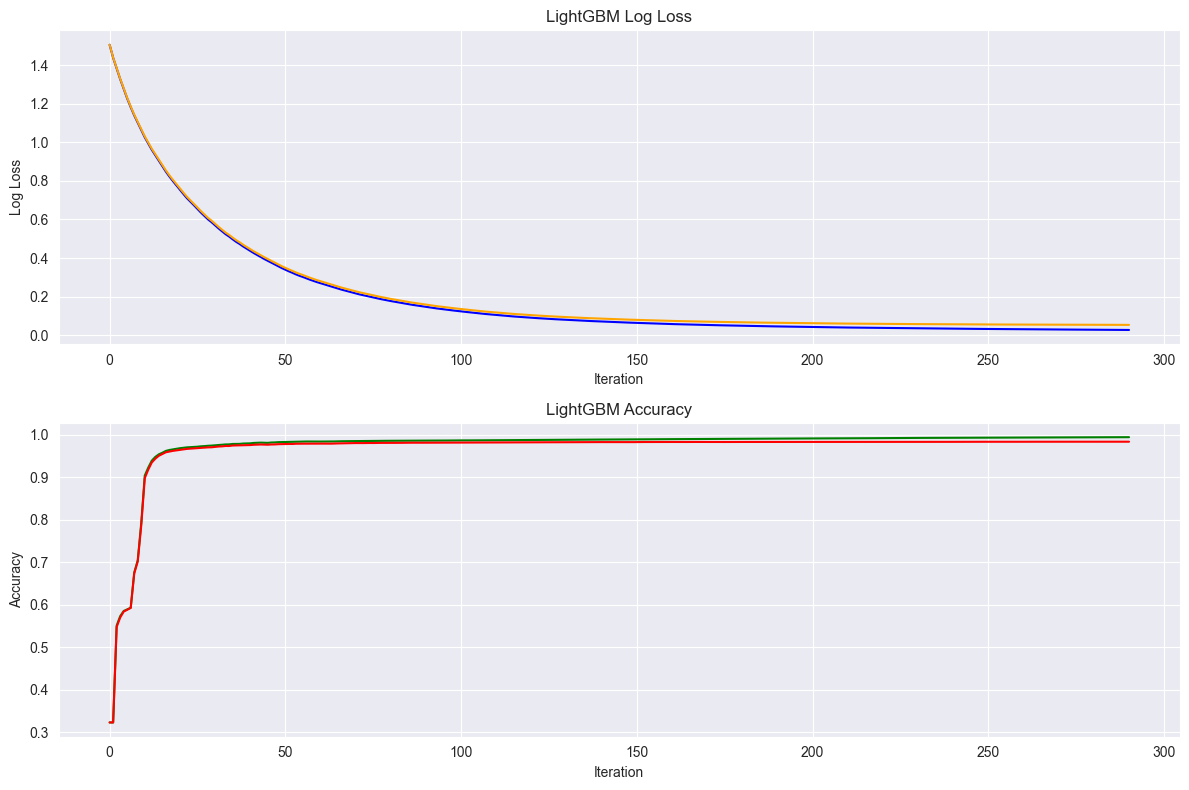

In [ ]:
# Train the model on the 67% of the Hao dataset (training set) and validate on 33% and plot the Learning Curves to check overfitting
tuner.train_internal_split()
tuner.plot_learning_curve()

In [12]:
# Train on full Hao datasets and save final model
tuner.train_and_save_final_model_on_full_data(suffix='final')

In [13]:
# Evaluate the trained model on the external Kotliarov dataset
report, cm, stats = tuner.evaluate_on_external_testset()

In [14]:
# Print results

# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.990,0.983,0.987,5828.000
DC,0.973,0.680,0.800,646.000
Mono,0.774,0.997,0.871,7851.000
NK,0.901,0.967,0.933,4722.000
T CD4,0.914,0.885,0.899,20119.000
T CD8,0.936,0.771,0.846,9780.000
macro avg,0.915,0.880,0.889,48946.000
weighted avg,0.905,0.897,0.896,48946.000
accuracy,NaN,NaN,NaN,0.897


LightGBM - Tuned Model - Classification Report:
Accuracy: 89.7%
Recall: 88.04%
Specificity: 97.67%
PPV: 91.49%
NPV: 97.6%
F1: 88.94%


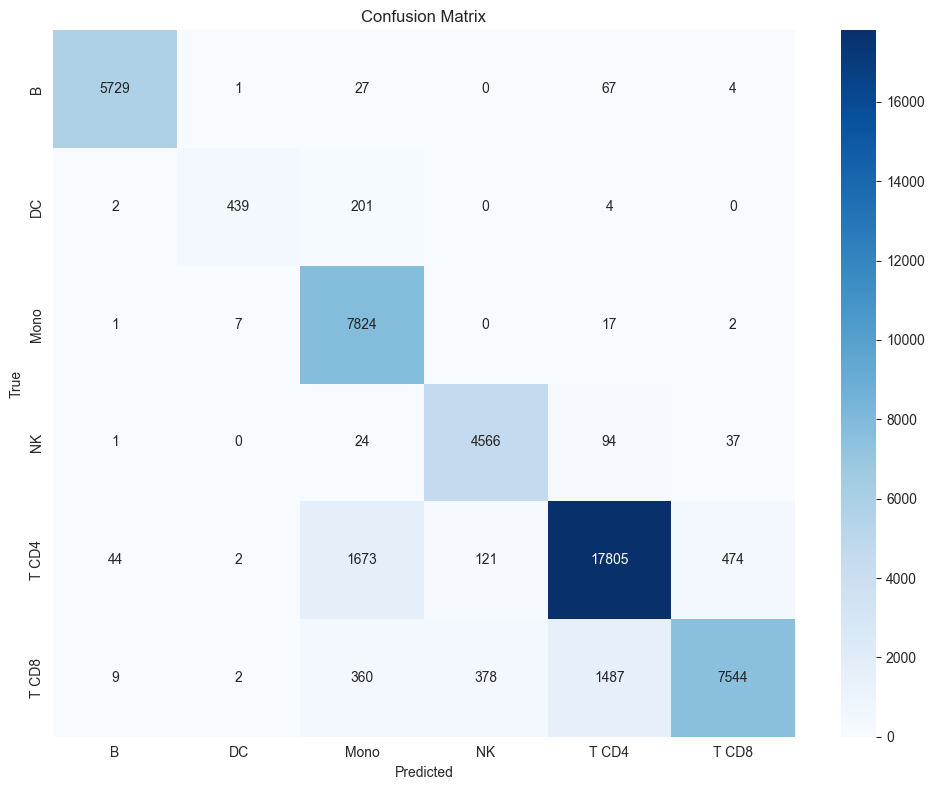

In [15]:
# Print stats
print("LightGBM - Tuned Model - Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
tuner.plot_confusion_matrix(cm)

# Baseline vs Tuned

In [16]:
# Load training set to get feature names in correct order
hao = pd.read_csv("../data/hao.csv", index_col=0)
expected_features = hao.drop(columns=["label"]).columns

In [17]:
# Load Kotliarov test data (same format as hao.csv)
kotliarov = pd.read_csv("../data/kotliarov.csv", index_col=0)
X_kot = kotliarov.drop(columns=["label"])
y_kot = kotliarov["label"]

# Align Kotliarov features to match training features
X_kot_aligned = X_kot[expected_features]

In [18]:
def get_pipeline(loaded_obj):
    """Extracts pipeline from loaded object (handles both tuple and non-tuple cases)"""
    return loaded_obj[0] if isinstance(loaded_obj, tuple) else loaded_obj

In [19]:
io = DiskIO("../models")

baseline_model = get_pipeline(io.load("LightGBM"))
tuned_model = get_pipeline(io.load("LightGBM", "final"))
label_encoder = get_pipeline(io.load("label_encoder_final"))

In [20]:
# Get the list of class labels the encoder was originally trained on
known_labels = label_encoder.classes_

# Create a boolean mask to keep only samples with labels the encoder recognizes
# This is necessary to avoid transforming labels that were not seen during training (would raise an error)
valid_mask = y_kot.isin(known_labels)

# Align test features with training feature order and keep only valid rows
# Note: 'expected_features' must match the training set columns exactly
X_kot_aligned = X_kot[valid_mask][expected_features]

# Filter the test labels to include only valid rows (i.e., rows with known labels)
y_kot_filtered = y_kot[valid_mask]

# Transform the filtered string labels into numerical form using the trained encoder
y_kot_encoded = label_encoder.transform(y_kot_filtered)

---

In [21]:
def calculate_bootstrap_ci(pipeline, X, y, metrics=None, n_bootstrap=1000, random_state=None):
    """Standalone bootstrap CI calculation for any model"""
    metrics_calc = MetricsCalculator(metrics=metrics or ['Accuracy', 'Recall', 'Specificity', 'PPV', 'NPV', 'F1'])
    metric_names = metrics_calc.METRICS
    metrics_dict = {name: [] for name in metric_names}
    
    rng = np.random.RandomState(random_state)
    
    for _ in range(n_bootstrap):
        indices = rng.choice(len(y), size=len(y), replace=True)
        X_bs = X.iloc[indices] if hasattr(X, 'iloc') else X[indices]
        y_bs = y[indices]

        metrics = metrics_calc.compute(y_bs, pipeline.predict(X_bs))
        
        for name, value in metrics.items():
            metrics_dict[name].append(value / 100)  # Convert percentage to ratio
    
    ci = {}
    for metric, values in metrics_dict.items():
        ci[metric] = {
            'mean': np.mean(values),
            'std_error': np.std(values, ddof=1),  # SEM
            'lower': np.percentile(values, 2.5),
            'upper': np.percentile(values, 97.5)
        }
    
    return ci

---

In [22]:
# Initialize metrics calculator
metrics_calculator = MetricsCalculator()

# Get point estimates (non-bootstrap)
baseline_metrics = metrics_calculator.compute_from_model(baseline_model, X_kot_aligned, y_kot_encoded)
tuned_metrics = metrics_calculator.compute_from_model(tuned_model, X_kot_aligned, y_kot_encoded)  

# Get bootstrap distributions (for CIs)
baseline_ci = calculate_bootstrap_ci(baseline_model, X_kot_aligned, y_kot_encoded)
tuned_ci = calculate_bootstrap_ci(tuned_model, X_kot_aligned, y_kot_encoded)

In [23]:
# Formatted DataFrame

metrics = ['Accuracy', 'Recall', 'Specificity', 'PPV', 'NPV', 'F1']

# Create display-friendly DataFrame
results_df = pd.DataFrame([
    {
        'Metric': metric,
        'Baseline': f"{baseline_ci[metric]['mean']*100:.2f} ± {baseline_ci[metric]['std_error']*100:.2f}",
        'Baseline CI': f"[{baseline_ci[metric]['lower']*100:.2f}, {baseline_ci[metric]['upper']*100:.2f}]",
        'Tuned': f"{tuned_ci[metric]['mean']*100:.2f} ± {tuned_ci[metric]['std_error']*100:.2f}",
        'Tuned CI': f"[{tuned_ci[metric]['lower']*100:.2f}, {tuned_ci[metric]['upper']*100:.2f}]"
    } 
    for metric in metrics
])

print("\nModel Performance Comparison with Confidence Intervals")
print("="*85)
display(results_df)


Model Performance Comparison with Confidence Intervals


,Metric,Baseline,Baseline CI,Tuned,Tuned CI
0,Accuracy,88.26 ± 0.14,"[87.99, 88.52]",89.70 ± 0.13,"[89.44, 89.95]"
1,Recall,86.52 ± 0.33,"[85.86, 87.18]",88.06 ± 0.32,"[87.45, 88.70]"
2,Specificity,97.37 ± 0.03,"[97.31, 97.43]",97.67 ± 0.03,"[97.61, 97.73]"
3,PPV,89.03 ± 0.25,"[88.51, 89.50]",91.48 ± 0.18,"[91.14, 91.79]"
4,NPV,97.34 ± 0.03,"[97.28, 97.40]",97.60 ± 0.03,"[97.54, 97.66]"
5,F1,86.87 ± 0.27,"[86.33, 87.38]",88.94 ± 0.25,"[88.43, 89.43]"


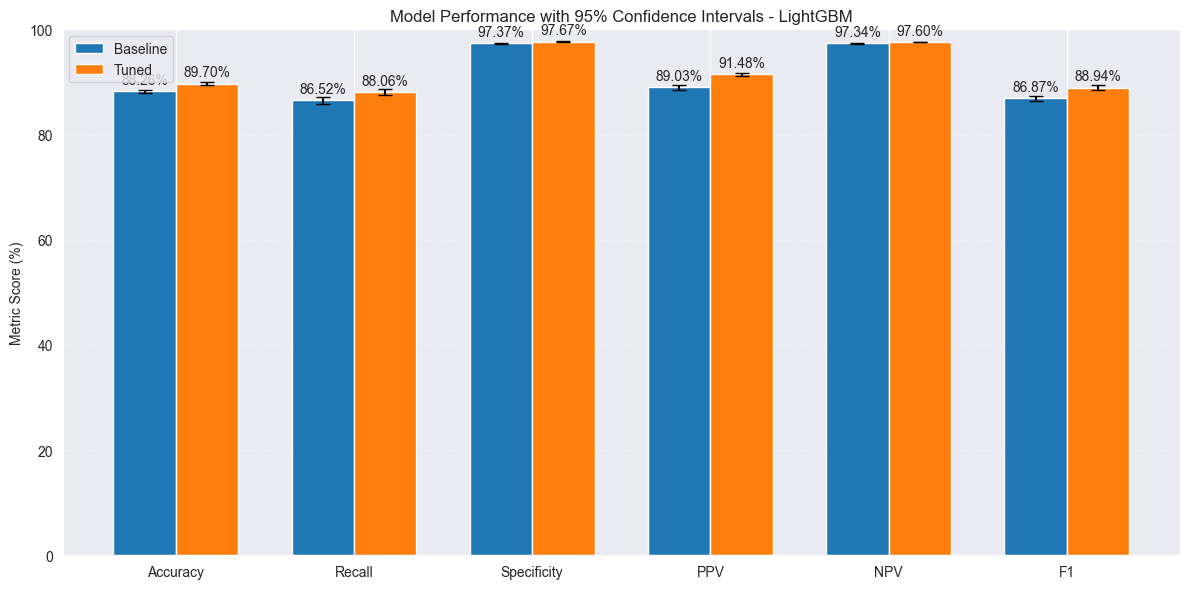

In [24]:
# Confidence Interval Plot

# Prepare numeric data for plotting
plot_data = pd.DataFrame({
    'Baseline Mean': [baseline_ci[m]['mean']*100 for m in metrics],
    'Tuned Mean': [tuned_ci[m]['mean']*100 for m in metrics]
}, index=metrics)

# Calculate error bars
err = np.empty((2, len(metrics), 2))  # 2(lower/upper) × metrics × models
for i, metric in enumerate(metrics):
    # Baseline errors
    err[0,i,0] = plot_data.loc[metric, 'Baseline Mean'] - baseline_ci[metric]['lower']*100
    err[1,i,0] = baseline_ci[metric]['upper']*100 - plot_data.loc[metric, 'Baseline Mean']
    # Tuned errors
    err[0,i,1] = plot_data.loc[metric, 'Tuned Mean'] - tuned_ci[metric]['lower']*100
    err[1,i,1] = tuned_ci[metric]['upper']*100 - plot_data.loc[metric, 'Tuned Mean']

# Create plot
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(metrics))
width = 0.35

# Plot bars
baseline_bars = ax.bar(x - width/2, plot_data['Baseline Mean'], width,
                      yerr=err[:,:,0], capsize=5, label='Baseline')
tuned_bars = ax.bar(x + width/2, plot_data['Tuned Mean'], width,
                   yerr=err[:,:,1], capsize=5, label='Tuned')

# Customize plot
ax.set_ylabel('Metric Score (%)')
ax.set_title('Model Performance with 95% Confidence Intervals - LightGBM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_ylim(0, 100)

# Add value labels
for bars in [baseline_bars, tuned_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3), textcoords="offset points",
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

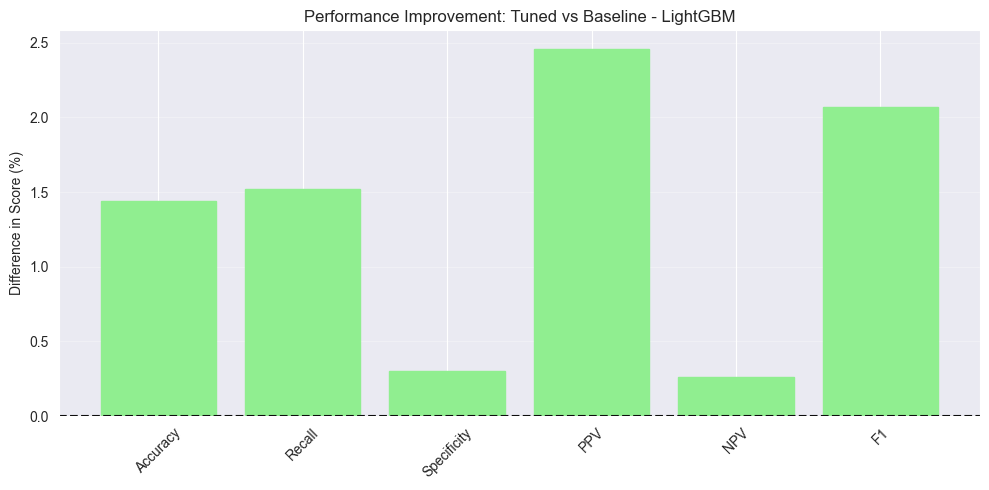

In [25]:
# Performance Difference Plot

# Calculate differences
baseline_values = [baseline_metrics[m] for m in metrics]
tuned_values = [tuned_metrics[m] for m in metrics]
diff = [t - b for t, b in zip(tuned_values, baseline_values)]

# Create difference plot
plt.figure(figsize=(10,5))
bars = plt.bar(metrics, diff, color='skyblue')
plt.axhline(0, color='black', linestyle='--')

# Highlight improvements
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('lightgreen')
    else:
        bar.set_color('salmon')

plt.title("Performance Improvement: Tuned vs Baseline - LightGBM")
plt.ylabel("Difference in Score (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Get predictions from both models
baseline_preds = baseline_model[0].predict(X_kot_aligned) if isinstance(baseline_model, tuple) else baseline_model.predict(X_kot_aligned)
tuned_preds = tuned_model[0].predict(X_kot_aligned) if isinstance(tuned_model, tuple) else tuned_model.predict(X_kot_aligned)

# Calculate agreement percentage
agreement = np.mean(baseline_preds == tuned_preds) * 100

# Print results
print(f"Model Prediction Agreement: {agreement:.2f}%")

Model Prediction Agreement: 94.91%


# Interpretation - SHAP

In [24]:
import shap

# Prepare background data for SHAP explainer
background_data = tuned_model.named_steps["scaler"].transform(X_kot_aligned.sample(100, random_state=42))

# Get the XGBoost model from the pipeline
xgb_model = tuned_model.named_steps["model"]

# Create SHAP explainer for the tuned model
explainer = shap.Explainer(xgb_model, background_data)

# Compute SHAP values for the (scaled) test set
X_kot_scaled = tuned_model.named_steps["scaler"].transform(X_kot_aligned)
shap_values = explainer(X_kot_scaled)

100%|===================| 293654/293676 [198:18<00:00]        

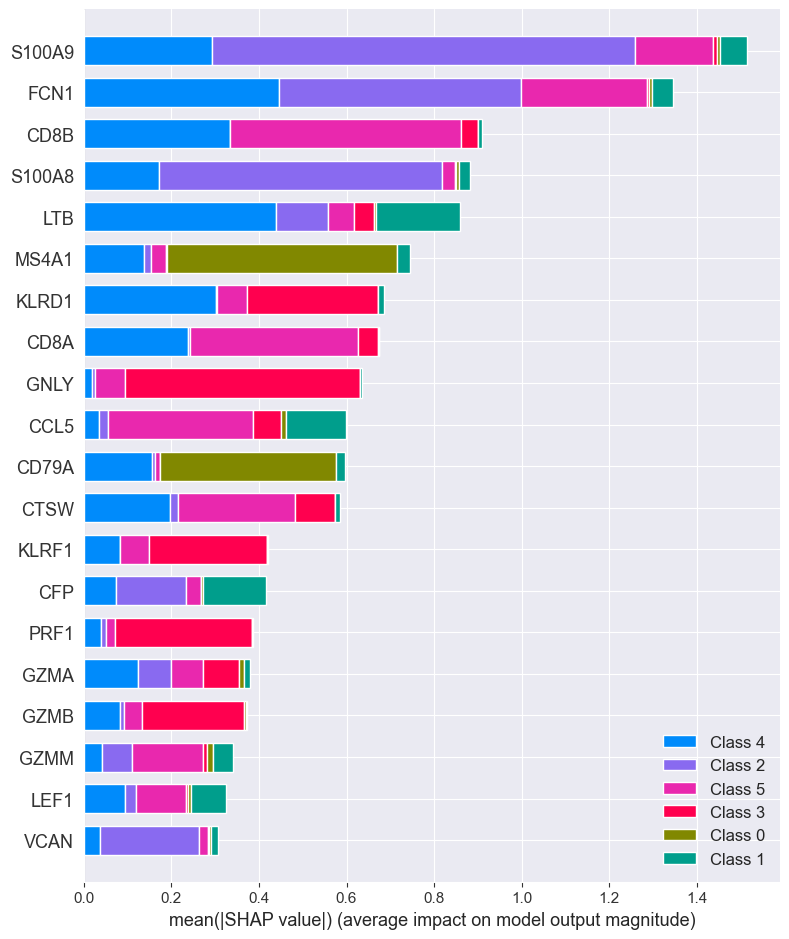

In [25]:
# Plot SHAP summary
shap.summary_plot(shap_values, X_kot_aligned, feature_names=expected_features, max_display=20, plot_type="bar")